## Escola Piloto Virtual - PEQ/COPPE/UFRJ
## Data Science e Machine Learning na Prática - Introdução e Aplicações na Indústria de Processos

Este notebook é referente à Aula 3 do curso, que trata do problema de classificação utilizando modelos de [redes neurais](https://en.wikipedia.org/wiki/Artificial_neural_network).

Serão dois estudos de caso, ambos constituindo aplicações do tipo [visão computacional](https://pt.wikipedia.org/wiki/Vis%C3%A3o_computacional):

* o [conjunto de dados MNIST](https://en.wikipedia.org/wiki/MNIST_database), talvez o exemplo mais famoso da área de aprendizado de máquina;
* um [conjunto de dados industrial](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product) com imagens de peças regulares e defeituosas resultantes de um [processo de fundição](https://pt.wikipedia.org/wiki/Fundi%C3%A7%C3%A3o).

In [1]:
# comandos mágicos que não se comunicam com a linguagem Python e sim diretamente com o kernel do Jupyter
# começam com %

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# importando os principais módulos que usaremos ao longo da aula

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics

from tensorflow import keras

In [3]:
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__)
print(keras.__version__)

1.18.5
1.1.2
3.2.1
0.10.0
0.23.2
2.4.0


# Videoaulas

Este notebook é explicado em detalhes ao longo das seguintes videoaulas:

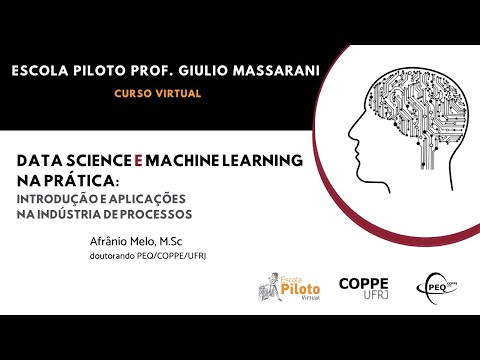

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo("EhXT_uWNuCg")

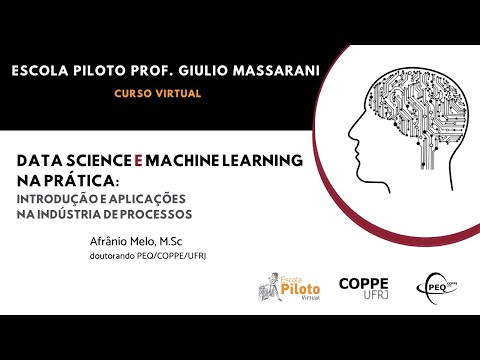

In [5]:
YouTubeVideo("e65Ix1T1N2U")

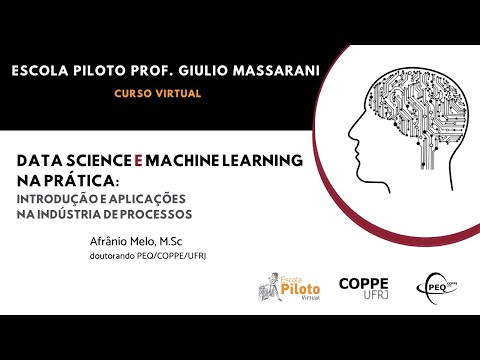

In [6]:
YouTubeVideo("cd-VSQeiPSM")

Para a playlist do curso completo, clique [aqui](https://www.youtube.com/playlist?list=PLvr45Arc0UpzsRhzq3q4_KmZcm0utwvvB).

# O conjunto de dados MNIST

O [conjunto de dados MNIST](https://en.wikipedia.org/wiki/MNIST_database) é composto de 70000 imagens de dígitos escritos por funcionários do [United States Census Bureau](https://en.wikipedia.org/wiki/United_States_Census_Bureau) e estudantes do ensino médio estadunidenses. Nossa missão aqui será criar modelos capazes de identificar o dígito de cada imagem.

## Importando dados

Os dados MNIST podem ser importados facilmente do `scikit-learn` ou do `keras`. No entanto, utilizaremos os dados disponíveis na [competição Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) do Kaggle:

In [7]:
mnist_PATH = '/kaggle/input/digit-recognizer/'

mnist_train = pd.read_csv(mnist_PATH+'train.csv')
mnist_test = pd.read_csv(mnist_PATH+'test.csv')

Inspecionando os dados:

In [8]:
mnist_train

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
41995       0  ...         0         0         0         0         0   
41996       0  ...         0         0         0         0         0   
41997       0  ...         0         0         0         0         0   
41998       0  ...         0         0         0         0         0   
41999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
41995         0         0         0         0         0  
41996         0         0         0         0         0  
41997         0         0         0         0         0  
41998         0         0         0         0         0  
41999         0         0         0         0         0  

[42000 rows x 785 columns]

Cada linha do DataFrame corresponde a uma imagem e cada coluna, a um pixel da imagem (com exceção da primeira coluna, `label`, que identifica o dígito). São 784 pixels, já que as imagens têm tamanho 28x28.

Separando os conjuntos `X` e `y`:

In [9]:
X, y = mnist_train.iloc[:,1:].values/255, mnist_train.iloc[:,0].values

X.shape, y.shape

((42000, 784), (42000,))

A divisão por 255 é uma normalização que converte os pixels da faixa 0-255 para a faixa 0-1, o que melhora o desempenho das redes neurais.

Usando o `matplotlib` para dar uma olhada nas imagens:

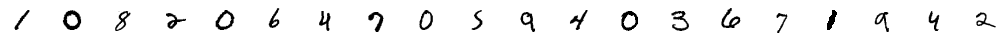

In [10]:
# localização dos exemplos na matriz de dados 
loc = [0,1,20,34,54,659,541,5200,11200,16721,23000,24010,29050,30000,32000,34990,36000,37000,39000,41000]

# selecionando os dígitos, já no formato de matriz
digitos = [X[i].reshape(28,28) for i in loc]

# criando figura do matplotlib
fig, ax = plt.subplots(1,len(loc),figsize=(18,0.5))

# plotando!
[ax[i].imshow(digitos[i], cmap = matplotlib.cm.binary, interpolation="nearest") for i in range(len(loc))]

# desligando os eixos de todos os dígitos
[ax[i].axis('off') for i in range(len(loc))];

Como os dados são provenientes da [competição Digit Recognizer](https://www.kaggle.com/c/digit-recognizer), apenas 42000 imagens estão disponíveis no conjunto (as outras 28000 são reservadas para teste). Incentivo que você se inscreva na competição e submeta os resultados dos vários modelos que criaremos ao longo da aula, de modo a verificar os respectivos desempenhos no conjunto de teste. Antes de submeter, não esqueça de retreinar os modelos no conjunto de treino completo (sem a separação treino/validação).

## Separando treino-validação

Para separar treino/validação, usaremos a função `train_test_split`:

In [11]:
X_treino, X_validacao, y_treino, y_validacao = sklearn.model_selection.train_test_split(X, y, 
                                                                                        test_size=0.1, 
                                                                                        random_state=0)

y_treino.shape, y_validacao.shape

((37800,), (4200,))

É útil verificar se as proporções de dígitos no treino e na validação são parecidas:

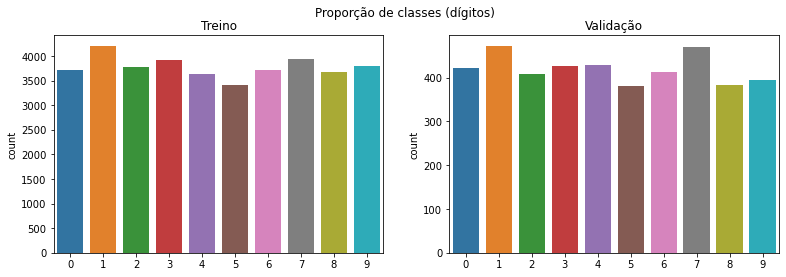

In [12]:
fig, ax = plt.subplots(1,2,figsize=(13,4))

sns.countplot(y_treino,ax=ax[0])
sns.countplot(y_validacao,ax=ax[1])

ax[0].set_title('Treino')
ax[1].set_title('Validação')

fig.suptitle('Proporção de classes (dígitos)');

As proporções entre classes parecem bem balanceadas em ambos os conjuntos.

# Rede MLP no scikit-learn

Antes de entrarmos nos belos detalhes matemáticos dos modelos de redes neurais, vamos utilizar o [modelo disponível no scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), conhecido como  [MLP (Multilayer perceptron)](https://en.wikipedia.org/wiki/Multilayer_perceptron), para implementar uma solução inicial utilizando a API que já nos é familiar:

In [13]:
m = sklearn.neural_network.MLPClassifier(random_state=0)

%time m.fit(X_treino, y_treino)

CPU times: user 52.8 s, sys: 63 ms, total: 52.9 s
Wall time: 53.4 s


MLPClassifier(random_state=0)

Efetuando a predição nos dados de validação:

In [14]:
y_validacao_pred = m.predict(X_validacao)

Comparando valores verdadeiros e predições:

In [15]:
print(y_validacao)
print(y_validacao_pred)

[3 6 9 ... 9 3 7]
[3 6 9 ... 9 8 7]


Dos seis valores mostrados, percebemos que o modelo tomou um 3 por um 8 (deve ser um erro recorrente, dada a semelhança entre os dígitos).

Uma métrica de desempenho bastante usada em problemas de classificação é a acurácia, ou seja, a simples proporção de predições verdadeiras. Ela está disponível em [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html):

In [16]:
acc_tr = sklearn.metrics.accuracy_score(y_treino, m.predict(X_treino))
acc_val = sklearn.metrics.accuracy_score(y_validacao, y_validacao_pred)

print(f'Acurácia do treino: {acc_tr}')
print(f'Acurácia da validação: {acc_val}')

Acurácia do treino: 1.0
Acurácia da validação: 0.9726190476190476


Parece um bom desempenho! Com um pequeno grau de sobreajuste, mas nada grave.

Para maior detalhamento do resultado, podemos usar a [matriz de confusão](https://en.wikipedia.org/wiki/Confusion_matrix), disponível em [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix):

In [17]:
confusao = sklearn.metrics.confusion_matrix(y_validacao, y_validacao_pred)
confusao

array([[413,   0,   1,   2,   0,   0,   2,   1,   2,   1],
       [  0, 465,   3,   2,   0,   0,   1,   1,   1,   0],
       [  1,   1, 399,   1,   0,   0,   1,   2,   4,   0],
       [  0,   1,   2, 408,   1,   3,   0,   3,   7,   1],
       [  1,   1,   0,   0, 419,   0,   3,   3,   0,   2],
       [  0,   0,   0,   2,   1, 373,   4,   0,   1,   1],
       [  0,   0,   1,   0,   1,   1, 409,   0,   0,   0],
       [  1,   2,   2,   1,   2,   2,   0, 457,   1,   1],
       [  0,   2,   0,   1,   2,   3,   5,   0, 370,   1],
       [  1,   0,   1,   3,   8,   1,   1,   5,   2, 372]])

Na matriz de confusão, o elemento $C_{ij}$ corresponde à quantidade de observações da classe $i$ que foi confundida com a classe $j$. O elemento da diagonal principal $C_{ii}$ corresponde à quantidade de predições corretas da classe $i$.

Nota-se que as maiores fontes de confusão são: 

* 9 sendo classificado como 4 (oito vezes);
* 3 sendo classificado como 8 (sete vezes);
* 8 sendo classificado como 6 (cinco vezes);
* 9 sendo classificado como 7 (cinco vezes).

A partir de agora, utilizaremos a função `display_score` para verificar o desempenho dos modelos:

In [18]:
def display_score(m):
        
    X = [X_treino, X_validacao]
    y = [y_treino, y_validacao]

    labels = ['Treino', 'Validação']
    
    if isinstance(m, keras.models.Sequential):
        if any([isinstance(l,keras.layers.Conv2D) for l in m.layers]):
            X = [X[i].reshape(-1,28,28,1) for i in (0,1)]
    
    y_pred = [m.predict(X[i]) for i in (0,1)]
    
    if isinstance(m, keras.models.Sequential):
        y_pred = [np.argmax(y_pred[i], axis=1) for i in (0,1)]

    confusao = [sklearn.metrics.confusion_matrix(y[i], y_pred[i]) for i in (0,1)]

    fig, ax = plt.subplots(1,2,figsize=(13,6.5))
    
    for i in (0,1):
        
        # dividindo cada valor da matriz pelo número total de imagens em cada classe
        row_sums = confusao[i].sum(axis=0, keepdims=True)
        confusao_normalizada = confusao[i] / row_sums

        # sumindo com a diagonal, pra podermos analizar só os erros:
        np.fill_diagonal(confusao_normalizada, 0)
        
        # plotando a matriz!
        ax[i].matshow(confusao_normalizada, cmap=plt.cm.Blues);
        
        # plotando os valores numéricos
        for j in range(len(confusao[i])):
            for k in range(len(confusao[i])):
                text = ax[i].text(k, j, confusao[i][j, k],
                               ha="center", va="center", color="w" if j!=k else "dodgerblue")
                
        # para exibir todos os números
        ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
        ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
        
        # título
        ax[i].set_title(f'{labels[i]}\nAcurácia: {sklearn.metrics.accuracy_score(y[i], y_pred[i]).round(4)}');

Utilizando a função:

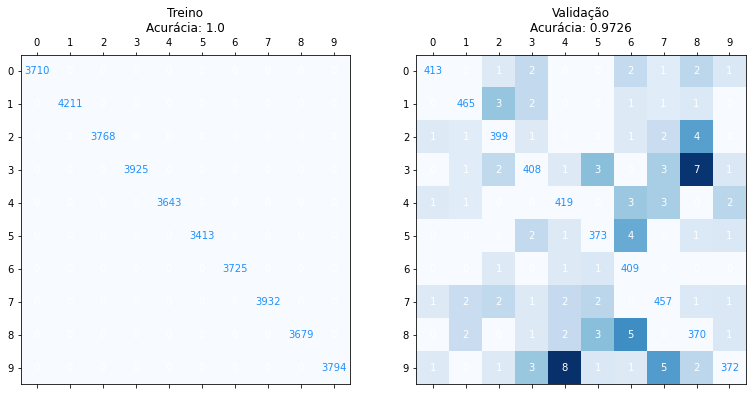

In [19]:
display_score(m)

Nas figuras acimas, para melhor visualização dos erros, as cores da diagonal foram zeradas e as cores de fora da diagonal foram normalizadas. Fica evidente o alto grau de sobreajuste, o que indica margem para melhoria do desempenho.

***Mão na massa 1!***

* Adicione ao kernel o conjunto de dados [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (no menu superior, clique em `File` e depois `Add or Upload Data`). Pesquise e entenda a natureza do conjunto. Quais classes estão presentes? Repita todo o procedimento que efetuamos acima para o conjunto MNIST:
    * separe em X e y;
    * separe em treino e validação;
    * visualize algumas amostras;
    * aplique uma rede MLP e meça o desempenho com a acurácia simples e a matriz de confusão.

# O que são redes neurais?

[Redes neurais artificiais](https://en.wikipedia.org/wiki/Artificial_neural_network) são uma classe de modelos de aprendizado inspirados vagamente no funcionamento do cérebro humano.

Esta é a estrutura de um [neurônio biológico](https://pt.wikipedia.org/wiki/Neur%C3%B3nio):

<img src="https://upload.wikimedia.org/wikipedia/commons/4/44/Neuron3.png" width="350" height="350"/>

* O corpo celular é o local dos componentes mais complexos da célula (núcleo, etc).

* Os [dendritos](https://pt.wikipedia.org/wiki/Dendrito) são pequenas e múltiplas ramificações do corpo celular.

* O [axônio](https://pt.wikipedia.org/wiki/Ax%C3%B3nio) é uma longa extensão (pode ser algumas ou milhares de vezes maior do que o corpo celular) em cujos terminais encontram-se as [sinapses](https://pt.wikipedia.org/wiki/Sinapse), que por sua vez se conectam aos dendritos ou corpos celulares de outros neurônios.

Cada neurônio individual apresenta um funcionamento bem simples. As características complexas dos sistemas nervosos biológicos emergem da auto-organização dos neurônios em vastas e complexas redes contendo bilhões de células, cada uma podendo efetuar milhares de conexões. A informação é processada nas redes por meio de sinais elétricos que cada neurônio recebe e transmite através das sinapses nervosas. As forças entre as conexões são ajustadas de acordo com estímulos externos. Esses ajustes são o mecanismo por meio do qual ocorre o processo de aprendizado em seres vivos.

O [neurônio matemático](https://en.wikipedia.org/wiki/Artificial_neuron) mimetiza o funcionamento do neurônio biológico:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/65/Artificial_neuron_2.gif" width="400" height="400"/>

* Cada neurônio $k$ em uma rede artificial é uma unidade de processamento local, que aceita $m$ conexões por meio das entradas $x_1$, $x_2$, ..., $x_m$ e fornece uma saída $y_k$.

* Cada conexão $i$ tem um peso associado, denotado por $w_{ki}$. O *aprendizado* da rede é efetuado por meio do ajuste desses pesos.

* A entrada $0$ não é uma conexão com um neurônio anterior, já que fornece sempre o mesmo valor $x_0=1$. Seu peso é denotado por $w_0 = b_k$ e chamado de viés (*bias*) do neurônio $k$. Fazendo analogia com o modelo linear, o viés é como se fosse o intercepto da reta.

* A saída $y_k$ do neurônio é expressa por:

$$ y_k = \varphi(v_k) = \varphi\left(\sum_{i=0}^m w_{ki} x_i\right)$$

* A função não-linear $\varphi$ é chamada de [função de ativação](https://en.wikipedia.org/wiki/Activation_function) e é responsável por introduzir não-linearidade nas redes. Se não houvesse uma função de ativação em cada neurônio, as redes só seriam capazes de aprender padrões lineares, já que o termo $v_k = \sum_{i=0}^m w_{ki} x_i$ é uma combinação linear dos sinais de entrada (cujos coeficientes são os pesos). Como veremos a seguir, existem várias possibilidades para a escolha da função de ativação.

* Nas redes neurais, os neurônios são dispostos em camadas, organizadas de acordo com a *arquitetura da rede*. Um exemplo de rede com três camadas (uma camada de entrada, uma camada oculta e uma camada de saída):

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c2/MultiLayerNeuralNetworkBigger_english.png" width="450" height="450"/>

* A camada de entrada não efetua nenhum cálculo e é responsável apenas por distribuir os sinais de entrada para as camadas internas.

* No treinamento das redes, os pesos $w$ das várias conexões são ajustados de modo que, para uma dada entrada, uma saída especificada seja gerada (lembre-se de que no aprendizado supervisionado, tanto entrada quanto saída estão disponíveis na etapa de treinamento).

* Após o treinamento, na etapa de predição, novos dados de entrada são alimentados e, caso o aprendizado tenha sido efetivo, saídas com baixo erro (ou seja, próximas das corretas) serão geradas pela rede.

* Quanto à arquitetura, as duas grandes classes de redes são as redes a) [recorrentes](https://en.wikipedia.org/wiki/Recurrent_neural_network) e b) de [alimentação direta](https://en.wikipedia.org/wiki/Feedforward_neural_network):

<img src="https://www.researchgate.net/publication/338672883/figure/fig1/AS:864764884422656@1583187423806/The-comparison-between-Recurrent-Neural-Network-RNN-and-Feed-Forward-Neural-Network.jpg
" width="400" height="400"/>

* Nas redes recorrentes, o sinal pode ser propagado para trás, enquanto nas redes de alimentação direta, o sinal só se propaga em um sentido. 

* As redes recorrentes são úteis para modelar dados em que há dependência entre as observações, como processos dinâmicos, textos ou sequências.

* Neste notebook, só serão estudadas redes de alimentação direta.

## Percéptron

O [percéptron](https://en.wikipedia.org/wiki/Perceptron), inventado por [Frank Rosenblatt](https://en.wikipedia.org/wiki/Frank_Rosenblatt) em 1957, foi uma das primeiras redes neurais propostas. Em sua forma original, consiste de uma camada de neurônios (ou mesmo apenas um neurônio) com a seguinte função de ativação:

$$   \varphi(u)= 
\begin{cases}
    0, & \text{se } u\leq 0\\
    1,          &    \text{se } u> 0.
\end{cases}
$$

$\varphi(u)$ é chamada de [função degrau de Heaviside](https://en.wikipedia.org/wiki/Heaviside_step_function). O uso dessa ativação resulta em um comportamento análogo ao do neurônio biológico (que dispara ou não um sinal de saída para os próximos neurônios a depender das intensidades dos sinais de entrada).

Apesar da grande simplicidade, a empolgação com o percéptron foi grande, já que era a época do surgimento da Inteligência Artificial! A máquina [Mark I Perceptron](https://apps.dtic.mil/dtic/tr/fulltext/u2/236965.pdf) foi construída para implementar o modelo:

<img src="https://upload.wikimedia.org/wikipedia/en/5/52/Mark_I_perceptron.jpeg
" width="250" height="250"/>

Após a empolgação inicial, logo percebeu-se que os percéptrons tinham muitas limitações, uma delas de natureza teórica: não era possível fazer com que o modelo representasse algumas funções simples. 

A solução para esse problema veio de um resultado muito importante chamado de [Teorema da Aproximação Universal](https://en.wikipedia.org/wiki/Universal_approximation_theorem), cujo enunciado afirma que:

* redes com uma camada oculta conseguem aproximar qualquer função contínua;
* redes com mais de uma camada oculta conseguem aproximar qualquer função.

Uau! Está garantido que, em tese, o uso de mais camadas nas redes neurais possibilita a resolução de uma enorme classe de problemas! No entanto, apesar de encorajador, o teorema não diz nada sobre os procedimentos necessários para fazer isso acontecer. Ou seja: como treinar redes com múltiplas camadas??

Obs: para uma visualização bem interessante do teorema da aproximação universal, recomendo [esta leitura](http://neuralnetworksanddeeplearning.com/chap4.html).

## Treinamento das redes

Por muito tempo lutou-se para encontrar um algoritmo de treinamento eficaz para redes com várias camadas.

Até que [RUMERHALT *et al.* (1986)](http://www.cs.toronto.edu/~hinton/absps/pdp8.pdf) propuseram o revolucionário [algoritmo da retropropagação do erro](https://en.wikipedia.org/wiki/Backpropagation). Cada iteração desse algoritmo é dividida em duas etapas: 

* Na primeira etapa , chamada de passe direto, calcula-se a saída da rede. 
* Na segunda, o passe reverso, calcula-se o quanto cada camada contribui para o erro da camada anterior. Isso é efetuado de trás para frente, ou seja, da saída para a entrada, por meio da aplicação da [regra da cadeia](https://pt.wikipedia.org/wiki/Regra_da_cadeia) (isso mesmo, aquela do Cálculo 1!). 

O resultado da segunda etapa é uma medida eficiente do gradiente do erro ao longo de toda a rede, o que torna possível a aplicação do algoritmo do [gradiente descendente](https://en.wikipedia.org/wiki/Gradient_descent) para a minimização do erro. O algoritmo do gradiente descendente é um método de [minimização de funções](https://en.wikipedia.org/wiki/Mathematical_optimization) que, a cada passo (iteração), busca o mínimo na direção de maior inclinação da função. A figura a seguir ilustra a aplicação do algoritmo a uma superfície, partindo de três pontos distintos:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif" width="250" height="250"/>

Um dos pontos iniciais levou a um mínimo local, enquanto os outros dois chegaram ao que parece ser o mínimo global no domínio apresentado. Não há garantia de que o algoritmo convirja para o mínimo global.

A função objetivo a ser minimizada é chamada de [perda (*loss*)](https://en.wikipedia.org/wiki/Loss_function). O tamanho do passo que o algoritmo de minimização efetua na descida, a cada iteração, é chamado de [taxa de aprendizado](https://en.wikipedia.org/wiki/Learning_rate) e constitui talvez o hiperparâmetro mais importante do modelo.

Para que o algoritmo da retropropagação do erro funcionasse, os autores precisaram propor uma nova função de ativação:

$$\varphi(u) = \frac{1}{1+\exp(-u)},$$

a função de ativação [logística](https://en.wikipedia.org/wiki/Logistic_function). Isso foi necessário porque a função de Heaviside, muito utilizada até então, é composta de segmentos planos, não apresentando gradientes.

Podemos encarar a função logística como uma espécie de suavização da função de Heaviside:

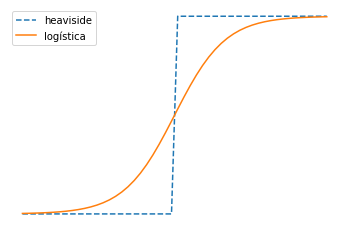

In [20]:
def logistic(u): return 1/(1 + np.exp(-u))

x = np.linspace(-6,6)
plt.plot(x,x>0,'--',label='heaviside')
plt.plot(x,logistic(x), label='logística')
plt.axis('off')
plt.legend();

### Detalhes sobre a minimização

#### Vários algoritmos

Existem várias técnicas pertencentes à família de algoritmos de gradiente descendente. Uma variante muito usada nas redes neurais é o [gradiente descendente estocástico (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), em que as derivadas são estimadas a partir de porções aleatórias dos dados, o que reduz problemas como mínimos locais e pontos de sela. 

A [estratégia de momentos](https://www.sciencedirect.com/science/article/abs/pii/S0893608098001166?via%3Dihub) consiste em adicionar a cada passo da iteração uma fração do passo anterior, o que pode amortecer oscilações e acelerar a descida em direções promissoras. Levar em conta essa fração do passo anterior também no cálculo do gradiente resulta na [estratégia de momentos de Nesterov](http://mpawankumar.info/teaching/cdt-big-data/nesterov83.pdf). O termo "momento" vem da analogia com a Física. 

Uma tendência recente é a utilização de taxas de aprendizado adaptativas, ou seja, atualizadas conforme a minimização evolui. O método Adam ([KINGMA e BA, 2014](https://arxiv.org/abs/1412.6980)), um dos mais usados atualmente, estende a estratégia de momentos descrita no parágrafo anterior adicionando um segundo momento, responsável por controlar a taxa de aprendizado. Esse segundo momento rastreia as variâncias dos gradientes de cada parâmetro ao longo dos passos anteriores. Quanto maior a variância dos gradientes passados de um dado parâmetro, mais o método diminui a taxa de aprendizado correspondente. O objetivo é atualizar mais os parâmetros que ainda não foram muito atualizados.

Para mais detalhes sobre algoritmos de gradiente descendente em redes neurais, confira [esta](https://ruder.io/optimizing-gradient-descent/) ou [esta](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) páginas.

Obs: pode-se ir além do gradiente descendente e utilizar outras técnicas, como as de segunda ordem (que utilizam informações de derivada segunda; exemplos são os métodos de [Newton](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) e [Quase-Newton](https://en.wikipedia.org/wiki/Quasi-Newton_method)) ou [meta-heurísticas](https://en.wikipedia.org/wiki/Metaheuristic). No entanto, tais aplicações são bem menos comuns.

#### Minilotes e épocas

Como vimos, nas variantes SGD do método de gradiente descendente, os dados são divididos aleatoriamente em pequenas porções. Cada porção é chamada de minilote (*minibatch*). 

Uma iteração do algoritmo de minimização é efetuada para cada minilote (ou seja, os erros são calculados e os pesos são atualizados a cada minilote processado).

Uma época (*epoch*) é marcada quando todos os minilotes foram processados (quando todo o conjunto de dados passou pela rede). Em outras palavras, o número de épocas é a quantidade de vezes em que cada dado é processado pela rede durante o treinamento. Geralmente, algumas épocas são necessárias para que se atinja um erro baixo.

#### Regularização

Uma crítica recorrente a modelos de redes neurais (e a modelos de aprendizado, de forma geral) é a grande quantidade de parâmetros de sua estrutura matemática. No mundo acadêmico, construiu-se um certo consenso de que modelos com muitos parâmetros são inerentemente ruins, por conta da complexidade matemática e da excessiva capacidade de adaptação resultantes. [Enrico Fermi](https://en.wikipedia.org/wiki/Enrico_Fermi), em 1953, ao criticar a complexidade de um modelo em específico, cunhou uma frase clássica sobre o assunto: 

"*With four parameters I can fit an elephant, and with five I can make him wiggle his trunk*". 

[MAYER *et al.* (2009)](https://publications.mpi-cbg.de/Mayer_2010_4314.pdf), em um artigo muito divertido, foram os primeiros a implementar de fato o elefante com quatro parâmetros (e a fazer a tromba balançar com um parâmetro adicional).

No entanto, os tempos mudam. Modelos de aprendizado profundo, que são incontestavelmente úteis (reconhecem rostos em imagens, traduzem textos, etc.), possuem milhares (ou milhões, ou mesmo [bilhões!!](https://www.microsoft.com/en-us/research/blog/turing-nlg-a-17-billion-parameter-language-model-by-microsoft/)) de parâmetros. Isso é possível porque existem estratégias desenvolvidas justamente para lidar com essa questão.

Uma das estratégias é a [regularização](https://en.wikipedia.org/wiki/Regularization_(mathematics)). Do ponto de vista matemático, a regularização é qualquer procedimento que adiciona informação a um problema com muitos graus de liberdade. No caso específico do aprendizado de máquina, a regularização é qualquer procedimento que tem como objetivo reduzir o erro de predição sem reduzir o erro do treinamento. 

Nas redes neurais, uma regularização muito usada é a regularização $L_2$, que adiciona à função perda um termo de penalização dos pesos $w$, na forma:

$$
\lambda \sum_i w_i^2
$$

Lembre-se de que o treinamento consiste na minimização da função perda por meio do ajuste dos pesos $w$. Quando a função perda possui um termo de regularização, o algoritmo tentará minimizar esse termo, se possível levando-o a zero. Para um parâmetro $w_i$ não resultar em zero, ele precisa ser muito importante, ou seja, *seu efeito na diminuição do erro tem de ser mais importante do que o efeito no aumento do erro causado pelo termo de regularização*. 

Moral da história: mesmo que o modelo tenha muitos parâmetros, nem todos são utilizados efetivamente no aprendizado, já que a regularização fará com que uma parte deles tenda a zero.

Observações:

* $\lambda$ é um hiperparâmetro que controla a intensidade da regularização. Valores típicos vão de $10^{-6}$ a $10^{-4}$.
* A regularização $L_1$ é análoga à $L_2$, no entanto usando valores absolutos no lugar dos quadrados.
* A regularização é utilizada em muitos modelos, não apenas em redes neurais. A regressão linear utilizando regularização $L_1$ é chamada de [regressão lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), enquanto a regularização $L_2$ dá origem à [regressão ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

## TensorFlow Playground

O [TensorFlow Playground](https://playground.tensorflow.org/) é uma página muito interessante para ganhar sentimento em relação ao funcionamento das redes neurais. Recomendo que você brinque um pouquinho com os diversos recursos e possibilidades oferecidas, em especial antes de fazer a atividade que vem a seguir.

***Mão na massa 2!***

* Analise a API da função [sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Com os conceitos apresentados acima, você deve ser capaz de entender a natureza da maior parte dos hiperparâmetros. Treine a rede nos conjuntos MNIST e Fashion MNIST mais vezes, variando alguns hiperparâmetros e observando os efeitos nos resultados.

Obs: há algumas referências, ([SMITH, 2018](https://arxiv.org/abs/1803.09820), por exemplo), em que você pode conferir dicas e boas práticas para essa tarefa.

# Rede MLP no Keras

Nosso primeiro contato com as redes foi por meio do `scikit-learn`, uma abordagem conveniente pois já tínhamos familiaridade com sua interface. Mas, na verdade, existem bibliotecas muito mais poderosas para utilização de redes neurais, que possibilitam a criação de modelos com diferentes arquiteturas e múltiplas camadas. São as chamadas bibliotecas de [aprendizado profundo (*deep learning*)](https://pt.wikipedia.org/wiki/Aprendizagem_profunda).

Em particular, aqui utilizaremos a biblioteca [keras](https://keras.io/), que oferece uma interface intuitiva para implementação de modelos de redes neurais com a possibilidade de utilização de diversos motores de cálculo (o motor utilizado aqui será o [TensorFlow](https://www.tensorflow.org/)).

Antes de entrarmos nos detalhes do aprendizado profundo, é interessante implementarmos no `keras` um modelo MLP semelhante ao que usamos no `scikit-learn`.

Para criar uma rede neural no `keras`, podemos inicializar o modelo utilizando a classe [keras.models.Sequential()](https://keras.io/api/models/sequential/) e ir adicionando as camadas sequencialmente com o método `add`:

In [21]:
m = keras.models.Sequential()

m.add(keras.layers.Dense(200, input_shape = (784,), activation="relu"))
m.add(keras.layers.Dense(10, activation="softmax"))

Adicionamos na rede acima duas camadas (além da camada de entrada, que não precisa ser explicitamente adicionada), ambas definidas com a classe [keras.layers.Dense](https://keras.io/api/layers/core_layers/dense/). Uma camada densa é aquela em que os neurônios estão conectados a todos os neurônios da camada anterior.

São 200 neurônios na camada oculta. A entrada reflete a dimensionalidade das imagens (784 pixels). A função de ativação [relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (hoje mais prestigiada do que a velha logística) é usada também no default do MLP do `scikit-learn` e será explicada mais adiante. 

São 10 neurônios na camada de saída, correspondentes às 10 classes (aos 10 possíveis dígitos). A função [softmax](https://en.wikipedia.org/wiki/Softmax_function), a última etapa da rede, é a responsável por transformar a saída em um vetor de probabilidades (um vetor de soma 1 composto por números entre 0 e 1):

$$\sigma(\mathbf{u})_i = \frac{e^{u_i}}{\sum_{j=1}^K e^{u_j}} $$

Dessa maneira, a entrada da rede é uma imagem de 784 pixels e a saída é um vetor de 10 elementos, cada um deles descrevendo a probabilidade da imagem corresponder a um dos dígitos entre 0 e 9.

É possível verificar a qualquer momento a estrutura do modelo com a função [summary()](https://keras.io/api/models/model/#summary-method):

In [22]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________


Perceba a grande quantidade de parâmetros, mesmo em uma rede com apenas uma camada oculta!

Antes de treinar o modelo, é preciso compilá-lo, definindo a função perda, o otimizador e as métricas de avaliação:

In [23]:
m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

A função [entropia cruzada](https://pt.wikipedia.org/wiki/Entropia_cruzada) vem da [teoria da informação](https://pt.wikipedia.org/wiki/Teoria_da_informa%C3%A7%C3%A3o) e mede a distância entre duas distribuições de probabilidade. Para duas distribuições $y$ e $p$, a entropia cruzada é escrita como:

$$ - \sum_{j} y_{j} \log \, p_{j} $$

Nas aplicações de redes neurais para classificação, as distribuições $y$ e $p$ são substituídas pelos vetores $\mathbf{y}$ (o vetor verdadeiro de probabilidades de cada classe) e $\mathbf{p}$ (o vetor de probabilidades de cada classe predito pela rede).

Como temos certeza sobre a classe verdadeira nas amostras de treinamento, na verdade os vetores verdadeiros de probabilidades $\mathbf{y}$ tem a forma: $[0,0,..1,..0]$ (representação *one-hot encoding*). 

Por exemplo, em certa aplicação o vetor $\mathbf{y}$ poderia ser:

$$
\mathbf{y} = [0,0,0,1,0,0,0,0,0,0],
$$

o que significa dizer que temos certeza de que o valor verdadeiro é 3. 

O vetor $\mathbf{p}$ poderia ser:

$$
\mathbf{p} = [0,0,0,0.98,0,0.02,0,0,0,0],
$$

o que significa dizer que a rede prevê que 98% de certeza que o valor é 3.

A entropia cruzada entre $\mathbf{y}$ e $\mathbf{p}$ seria:

$$-1\cdot\log(0.98) = -0.00877$$

A função perda é definida como a média das várias entropias cruzadas das $M$ classes para todas as amostras $N$ do conjunto (ou do minilote):

$$ - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} \log \, p_{ij} $$

É a função acima que a rede tenta minimizar durante o treinamento, manipulando os pesos das conexões.

Pronto! Já implementamos o modelo e entendemos os detalhes matemáticos. Podemos enfim treinar:

In [24]:
%%time 

H = m.fit(X_treino, y_treino, 
          batch_size = 200, epochs = 10, 
          validation_data = (X_validacao, y_validacao));

Epoch 1/10
189/189 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.8776 - val_loss: 0.2455 - val_accuracy: 0.9348
Epoch 2/10
189/189 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9439 - val_loss: 0.1889 - val_accuracy: 0.9476
Epoch 3/10
189/189 [==============================] - 0s 2ms/step - loss: 0.1433 - accuracy: 0.9593 - val_loss: 0.1597 - val_accuracy: 0.9560
Epoch 4/10
189/189 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.9690 - val_loss: 0.1352 - val_accuracy: 0.9617
Epoch 5/10
189/189 [==============================] - 1s 3ms/step - loss: 0.0891 - accuracy: 0.9752 - val_loss: 0.1234 - val_accuracy: 0.9645
Epoch 6/10
189/189 [==============================] - 1s 3ms/step - loss: 0.0730 - accuracy: 0.9801 - val_loss: 0.1165 - val_accuracy: 0.9660
Epoch 7/10
189/189 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9830 - val_loss: 0.1114 - val_accuracy: 0.9686
Epoch 

Ufa! Deu bem mais trabalho do que o modelo do `scikit-learn`, pois foi preciso definir muito mais detalhes. Em compensação, o desempenho computacional foi bem melhor.

O atributo `history` do objeto `H` possibilita que analisemos a evolução das métricas e valores da função perda para os dados de treino e validação:

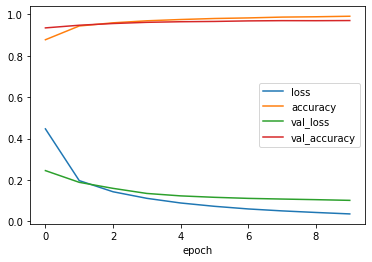

In [25]:
pd.DataFrame(H.history).plot();
plt.xlabel('epoch');

Os resultados já são bons mesmo na primeira época e vão melhorando lenta e continuamente conforme o treinamento evolui. As curvas de treino e validação estão próximas, um indicativo de que não há muito sobreajuste.

Podemos usar o método `evaluate` para avaliar rapidamente o desempenho final do modelo:

In [26]:
m.evaluate(X_validacao, y_validacao);

132/132 [==============================] - 0s 2ms/step - loss: 0.1018 - accuracy: 0.9702


Analisando as matrizes de confusão utilizando nossa função `display_score`:

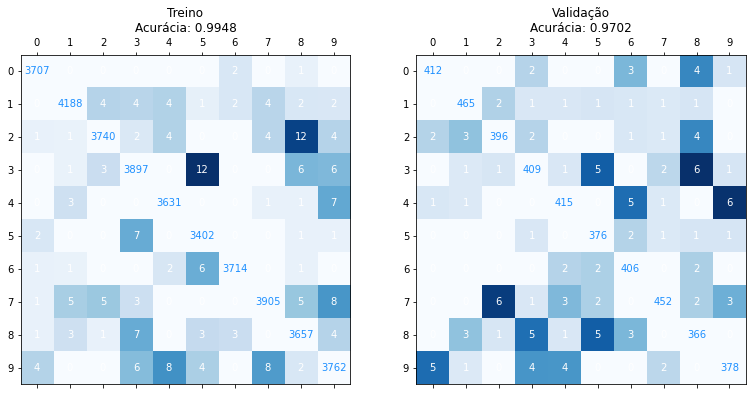

In [27]:
display_score(m)

O desempenho é parecido com o que obtivemos com a rede MLP do `scikit-learn`, com a diferença de que parece haver menos sobreajuste. 

Para melhorar o resultado, utilizaremos redes com múltiplas camadas, que constituem o principal objeto de estudo do [aprendizado profundo (*deep learning*)](https://pt.wikipedia.org/wiki/Aprendizagem_profunda). Em particular, utilizaremos uma arquitetura especialmente apropriada para aplicações de visão computacional, as chamadas [redes convolucionais](https://en.wikipedia.org/wiki/Convolutional_neural_network).

# Aprendizado Profundo

[GOODFELLOW *et al.* (2016)](https://www.deeplearningbook.org/) propuseram uma excelente definição de aprendizado profundo:

"*O aprendizado profundo é um tipo específico de aprendizado de máquina que alcança grande poder e flexibilidade ao representar o mundo como uma hierarquia aninhada de conceitos, sendo i) cada conceito definido por meio de sua relação com conceitos mais simples e ii) representações mais abstratas calculadas em termos de outras menos abstratas.*"

Ou seja, em um modelo de aprendizado profundo, os padrões reconhecidos a partir dos dados são organizados em múltiplas camadas. Quanto mais fundo se avança nas camadas do modelo, mais os padrões vão se tornando complexos e abstratos. As redes neurais, justamente por conta de sua organização natural em camadas, são o tipo de modelo de escolha para tais aplicações. Para uma leitura sobre aprendizado profundo complementar a este notebook, recomendo o artigo de [LECUN *et al.* (2015)](https://www.nature.com/articles/nature14539).

Apesar de a ideia ser antiga, o treinamento de redes com muitas camadas sempre se mostrou bem difícil, mesmo com o advento do algoritmo da retropropagação do erro em 1986. Historicamente, os grandes problemas foram:

1. treinamentos excessivamente lentos;
2. gradientes que desaparecem ou explodem ao serem retropropagados pela rede;
3. escassez de dados para treinamento;
4. risco de sobreajuste por conta do excesso de parâmetros.

[HINTON *et al.* (2006)](https://www.mitpressjournals.org/doi/10.1162/neco.2006.18.7.1527) foram os primeiros a demonstrar a possibilidade de atenuação dos problemas 1 e 3 para treinamento de redes profundas, utilizando uma metodologia de pré-treinamento não supervisionado. Este trabalho reviveu o interesse da comunidade científica e tecnológica nas redes neurais. A estratégia proposta foi muito popular, mas caiu em desuso na década de 2010, quando novas soluções para os problemas foram surgindo. A seguir, abordaremos as mais influentes e utilizadas hoje em dia.

### Problema 1: treinamentos excessivamente lentos

[RAINA *et al.* (2009)](http://www.robotics.stanford.edu/~ang/papers/icml09-LargeScaleUnsupervisedDeepLearningGPU.pdf) propuseram o uso de [GPU's (Unidades Gráficas de Processamento)](https://en.wikipedia.org/wiki/Graphics_processing_unit) para efetuar o treinamento das redes profundas de forma massivamente paralela, o que se mostrou essencial para aplicações em larga escala. Um dos motivos para tal aplicação ter sido tão bem-sucedida é que já havia pressão econômica para desenvolvimento de GPU's antes do uso pela comunidade científica, vinda principalmente da indústria de videogames. Você pode verificar a relevância da metodologia rodando os próximos códigos deste notebook com GPU's ativadas e depois somente com CPU's e comparando os desempenhos.

Outro fator que vem contribuindo para a melhoria de desempenho dos treinamentos é o surgimento de novas metodologias de minimização por gradiente descendente, como a [Adam](https://arxiv.org/abs/1412.6980), já citada.

### Problema 2: desaparecimento/explosão de gradientes

Mesmo com o grande ganho de eficiência introduzido pelas GPU's, sérias dificuldades numéricas relativas ao treinamento de redes profundas persistiram. Em particular, durante a etapa de retropropagação do erro, era inevitável que [os gradientes zerassem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), impedindo a convergência do treinamento. Em redes recorrentes é comum o problema inverso, a explosão dos gradientes.

[GLOROT e BENGIO (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), em um trabalho muito influente, identificaram os principais culpados para o fenômeno do desaparecimento dos gradientes:

* a até então popular função de ativação logística;
* a até então popular estratégia de inicialização dos pesos com uma distribuição gaussiana de média $0$ e desvio-padrão $1$.

Com essa combinação, a cada camada, a variância da saída resulta maior que da entrada, fazendo os sinais crescerem (positiva ou negativamente) até saturarem nas extremidades da função de ativação logística. Com a propagação de um sinal praticamente constante ao longo da rede, o gradiente na etapa de retropropagação (o sinal reverso) resulta praticamente nulo.

Desde então, várias boas práticas vêm sendo propostas para garantir que haja uma efetiva propagação dos sinais pela rede (tanto as predições, no sentido direto; quanto os gradientes, no sentido reverso), dentre as quais citamos:

* novas funções de ativação;
* novas estratégias de inicialização dos pesos;
* normalização por lote.

#### Novas funções de ativação

As funções de ativação mais usadas atualmente são da classe de [retificadores lineares](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). Abaixo apresentamos alguns exemplos, junto à função logística:

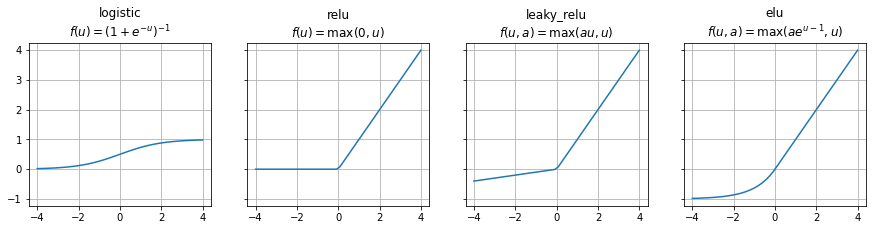

In [28]:
def logistic(u): 
    return 1/(1 + np.exp(-u))
def relu(u): 
    return np.where(u > 0, u, 0)
def leaky_relu(u, a = 0.1): 
    return np.where(u > 0, u, a*u)
def elu(u, a=1): 
    return np.where(u > 0, u, a*(np.exp(u)-1))
          
funcs = [logistic, relu, leaky_relu, elu]

formulas = ["$f(u) = (1+e^{-u})^{-1}$",
            "$f(u)=\max(0,u)$",
            "$f(u,a)=\max(au,u)$",
            "$f(u,a)=\max(ae^{u-1},u)$"]
    
fig, ax = plt.subplots(1,len(funcs), figsize=(15,3), sharey=True)
x = np.linspace(-4,4)
    
for i in range(len(funcs)):
    ax[i].plot(x,funcs[i](x));
    ax[i].grid('on');
    ax[i].set_title(funcs[i].__name__+'\n'+formulas[i])

No primeiro gráfico, da função logística, fica evidente como, para valores de $u$ afastados de $0$, os valores de $f(u)$ saturam.

No segundo gráfico, temos a função `ReLU`, a mais popular hoje em dia por dois motivos: não satura no sentido positivo e é rápida de calcular. É incrível como essa função, bem mais simples do que a logística, funciona tão melhor nas redes neurais e precisou esperar tantas décadas até ter seu uso disseminado! O provável motivo é a analogia que se pode fazer entre a função logística e os mecanismos de disparo do neurônio biológico (analogias são legais, mas não ajudam em nada os algoritmos matemáticos).

No terceiro gráfico, temos a função `Leaky ReLU`, que introduz uma inclinação na região negativa da `ReLU`. É uma estratégia para impedir a morte de neurônios (ou seja, quando a saída do neurônio é nula para todas as amostras de treinamento), situação comum em redes com ativação `ReLU`. Quando $a$ se torna um parâmetro a ser aprendido pela rede, como sugerido por [HE *et al.* (2015)](https://arxiv.org/abs/1502.01852), a função recebe o nome de `PReLU` (Parametric ReLU).

No quarto gráfico, temos a função `ELU`, proposta por [CLEVERT *et al.* (2015)](https://arxiv.org/abs/1511.07289). Sua maior vantagem é tornar a média das ativações mais próxima de $0$, o que acelera o aprendizado por proporcionar maior flexibilidade à minimização por gradiente descendente (detalhes [aqui](https://stats.stackexchange.com/questions/237169/)). Outra vantagem: quando $a=1$, a função é [suave](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_suave), uma conveniência numérica também útil na minimização. A desvantagem é que ela é mais lenta para calcular (compensada às vezes pela maior velocidade de convergência do treinamento).

Além dessas, há várias outras funções de ativação ([SELU](https://arxiv.org/abs/1706.02515), [GELU](https://arxiv.org/abs/1606.08415), etc.). Para uma discussão mais profunda, recomendo [esta leitura](https://mlfromscratch.com/activation-functions-explained/#/).

#### Novas estratégias de inicialização dos pesos

Lembre-se de que a maior dificuldade para o bom funcionamento de uma rede profunda é garantir a efetiva propagação dos sinais pela rede. Para esse objetivo, o ideal seria que a variância de um sinal (direto ou reverso) se mantivesse constante antes e depois de passar por uma camada. Isso não é possível quando a camada apresenta um número diferente de entradas em relação ao de neurônios, mas pode-se chegar próximo o suficiente dessa situação ideal por meio de estratégias inteligentes de inicialização de pesos.

[GLOROT e BENGIO (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) propuseram uma nova inicialização conhecida como *inicialização de Glorot* (ou *de Xavier*), [usada como default no keras](https://keras.io/api/layers/initializers/#glorotuniform-class) e ideal para [funções sigmóides](https://en.wikipedia.org/wiki/Sigmoid_function) (como a logística). [HE *et al.* (2015)](https://arxiv.org/abs/1502.01852) propuseram uma modificação na inicialização de Glorot para que funcionasse melhor com funções de ativação baseadas em retificadores lineares (`ReLU`, etc.), dando origem à *inicialização de He*. Ambas as estratégias envolvem amostragens aleatórias a partir de distribuições estatísticas com características específicas. Para detalhes, consulte [esta página](https://www.deeplearning.ai/ai-notes/initialization/).

#### Normalização por lote

A [normalização por lote](https://en.wikipedia.org/wiki/Batch_normalization) foi proposta por [IOFFE e SZEGEDY (2015)](https://arxiv.org/abs/1502.03167) e desde então aparece com frequência nas arquiteturas das redes neurais modernas. 

Uma [camada de normalização por lote](https://keras.io/api/layers/normalization_layers/batch_normalization/) aceita um vetor de entradas $\mathbf{x}$ e retorna uma saída $\mathbf{y}$ de mesmo comprimento, cujos elementos resultam da seguinte operação:

$$ y_i = \left(\frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}\right)\gamma +\beta, $$

em que:

* $\mu_B$ e $\sigma_B^2$ são a média e a variância do minilote utilizado no momento;
* $\gamma$ e $\beta$ são parâmetros a serem aprendidos pela rede;
* $\epsilon$ é um número fixo pequeno que ajuda a evitar problemas numéricos.

O termo dentro do parênteses é a simples normalização do sinal utilizando as estatísticas do minilote. O sucesso da proposta veio da introdução dos parâmetros $\gamma$ e $\beta$, que possibilitam que as saídas $y_i$ tenham *qualquer* média e variância (na verdade, esses valores são determinados de maneira ótima pela rede).

A normalização por lote possibilita que se utilize maiores taxas de aprendizado, diminui a sensibilidade da rede em relação à inicialização e atua como um regularizador, aumentando a capacidade de generalização do modelo. O porquê de ela funcionar tão bem ainda é uma questão em aberto. A explicação mais factível parece ser uma diminuição das influências dos pesos uns sobre os outros ao longo das várias camadas, o que suaviza a função objetivo e facilita a tarefa dos métodos de minimização. Para discussões interessantes a respeito, consulte [SANTUNKAR *et al.* (2019)](https://arxiv.org/abs/1805.11604) ou [esta](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/), [esta](https://mlexplained.com/2018/01/10/an-intuitive-explanation-of-why-batch-normalization-really-works-normalization-in-deep-learning-part-1/) e [esta](https://www.reddit.com/r/MachineLearning/comments/67mjuw/d_alternative_interpretation_of/) páginas.

### Problema 3: escassez de dados para treinamento

Este problema vem sendo aliviado principalmente por conta do cenário *big data*, com a cada vez maior quantidade de dados sendo gerada a partir das mais diversas fontes.

Nos casos em que há poucos dados para um problema em específico, podem ser utilizadas técnicas de [transferência de aprendizado](https://en.wikipedia.org/wiki/Transfer_learning), em que modelos treinados em uma situação (com muitos dados) podem ser aplicados a cenários similares (com menor disponibilidade de dados). No aprendizado profundo, por exemplo, podemos usar camadas genéricas pré-treinadas e treinar apenas as últimas camadas para uma situação em específico, usando poucos dados, como demonstrado [aqui](https://keras.io/guides/transfer_learning/). Essa é uma linha de pesquisa ainda pouco explorada e potencialmente muito frutífera.

### Problema 4: risco de sobreajuste por conta do excesso de parâmetros

Para esse problema, as velhas regularizações $L_1$ e $L_2$ podem ser boas soluções. Além delas, uma estratégia de regularização muito usada é a [dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)), proposta por [HINTON *et al.* (2012)](https://arxiv.org/abs/1207.0580), que consiste na desativação de uma certa parcela aleatória dos neurônios a cada passo do treinamento. É uma ideia simples, mas surpreendentemente efetiva para melhorar a capacidade de generalização das redes.

***Mão na massa 3!***

* Explore a [API do Keras](https://keras.io/api/) e aprenda como utilizar os recursos explicados aqui: funções de ativação, inicialização de pesos, normalização por lote e *dropout*. Aplique em alguns modelos MLP para os conjuntos MNIST e Fashion MNIST. Não fique preso ao que foi mencionado na aula: pesquise sobre e utilize outras funções de ativação, inicializações, etc.  O objetivo é que você ganhe familiaridade com a biblioteca e autonomia para navegar na API e implementar os recursos em seus modelos.

# Redes convolucionais

[Redes convolucionais](https://en.wikipedia.org/wiki/Convolutional_neural_network) são redes esparsamente conectadas, em que cada neurônio *não* se conecta a todos os neurônios da camada anterior. É o contrário das redes densamente conectadas, como a MLP, que estudamos até agora.

As redes densamente conectadas só podem aprender padrões globais, ou seja, padrões que envolvem todos os pontos presentes em dada amostra ou observação. Já as redes convolucionais, como veremos, são capazes de aprender *padrões locais* e reconhecer esses padrões em *qualquer posição* de alguma outra amostra. No caso de imagens, esses padrões locais podem corresponder a bordas, curvas etc.

Ao longo da estrutura da rede, conforme se avança nas camadas mais profundas, os padrões locais simples vão sendo agregados e tornando-se cada vez mais complexos. É uma estrutura de aprendizado análoga a que se observa no [córtex visual](https://en.wikipedia.org/wiki/Visual_cortex), estrutura do cérebro responsável pelo processamento da informação visual. Por isso as redes convolucionais são tão utilizadas para processar imagens.

Matematicamente, a rede efetua o aprendizado desses padrões locais por meio da operação de [convolução](https://en.wikipedia.org/wiki/Convolution), explicada a seguir.

## Funcionamento da rede convolucional

* Para alimentar uma imagem à rede, é necessário representá-la como um tensor. Por exemplo, a seguir é ilustrada a representação da imagem de um cãozinho como um tensor tridimensional de pixels:

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-47994-7_16/MediaObjects/472738_1_En_16_Fig2_HTML.png" width="600" height="600"/>

* No caso, o tensor resultante possui formato 15x20x3 (ou seja, são 15 linhas, 20 colunas e 3 canais de cores).

* Em seguida, a imagem passa por uma *camada convolucional*. Nessa camada, aplica-se a operação de convolução:

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-47994-7_16/MediaObjects/472738_1_En_16_Fig3_HTML.png" width="500" height="500"/>

* Na operação de convolução, um *filtro* (também chamado de *kernel*), em geral de dimensão 3x3 (a mais comum), 5x5 ou 7x7, percorre os pixels de uma imagem calculando o produto escalar a cada passo e armazenando os resultados em uma matriz chamada de *mapa de características*.

* O mapa de características recebe esse nome porque é a estrutura responsável por reconhecer os vários padrões (características) relativos à imagem. A natureza do padrão reconhecido depende da estrutura do filtro.

* Quando a imagem possui vários canais, o mapa de características resultante do filtro é a soma dos mapas de características correspondentes a cada canal.

* A camada convolucional pode ter vários filtros, cada um dando origem a um mapa de características.

* Cada elemento de um mapa de características corresponde a um neurônio. Os neurônios em um mesmo mapa de características compartilham os mesmos parâmetros (pesos).

* Em geral, a matriz de números que constitui cada filtro de dada camada é um parâmetro da rede, ou seja, é ajustada junto com os pesos de modo a resultar no aprendizado ótimo. O número de filtros de dada camada é um hiperparâmetro (deve ser determinado a priori).

* Os múltiplos mapas de características podem ser alimentados a uma nova camada convolucional, resultando em novos mapas, como ilustrado:

<img src="https://www.mdpi.com/sensors/sensors-19-01693/article_deploy/html/images/sensors-19-01693-g002-550.jpg" width="400" height="400"/>

* Cada neurônio de um mapa de características da saída conecta-se a apenas uma porção dos neurônios dos mapas da entrada. A porção da camada anterior que se conecta a um neurônio é chamada de seu *campo receptivo*. A figura a seguir ilustra bem o conceito de campo receptivo de um neurônio:

<img src="https://upload.wikimedia.org/wikipedia/commons/8/85/Convolution_arithmetic_-_Full_padding_no_strides_transposed.gif" width="200" height="200"/>

* A operação de convolução faz com que o mapa de saída tenha formato menor do que o mapa de entrada. De modo a fazer com que o formato seja o mesmo, pode-se utilizar estratégias de preenchimento (*padding*). Na estratégia a seguir, conhecida como *zero padding* ou *same padding*, adicionam-se zeros às bordas do mapa de entrada de modo que o mapa de saída possua o mesmo formato da entrada. É uma maneira de preservar as informações das bordas ao longo da rede.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/80/Convolution_arithmetic_-_Same_padding_no_strides_transposed.gif" width="200" height="200"/>

* Caso deseje-se gerar mapas de saída menores do que os de entrada, podem ser utilizados passos largos (*strides*). Na figura a seguir, o mapa é calculado com um stride de 2:

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_arithmetic_-_No_padding_strides.gif
" width="200" height="200"/>

* Outra estratégia para gerar mapas de saída menores que os da entrada é a *dilatação*, proposta por [YU e KOLTUN (2015)](https://arxiv.org/abs/1511.07122) e ilustrada na figura a seguir. A vantagem da dilatação em relação à estratégia de passos largos é a abrangência maior do campo receptivo de cada neurônio.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/Convolution_arithmetic_-_Dilation.gif" width="200" height="200"/>

* Além da camada convolucional, é comum adicionar às redes camadas de *pooling*. Assim como as camadas convolucionais, os neurônios das camadas de pooling também possuem campos receptivos, mas não há pesos e a operação efetuada não é a convolução e sim alguma operação de agregação, como a média ou a escolha do valor máximo (sendo essa última a mais usada):

<img src="https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png
" width="350" height="350"/>

* Em geral, os campos receptivos de pooling têm tamanho 2x2 e stride 2, como mostrado acima.

* As camadas de pooling diminuem a quantidade de parâmetros da rede, atenuando o sobreajuste e o custo computacional. Além do mais, como há agregação da informação de janelas maiores em janelas menores, os campos receptivos das camadas mais profundas da rede, mesmo sendo pequenos, possuem informações relativas à toda a imagem original. Isso possibilita a criação de padrões globais e mais complexos/abstratos nas camadas profundas.

* A figura a seguir ilustra a arquitetura típica de uma rede convolucional:

<img src="https://www.researchgate.net/publication/336805909/figure/fig1/AS:817888827023360@1572011300751/Schematic-diagram-of-a-basic-convolutional-neural-network-CNN-architecture-26.ppm" width="500" height="500"/>

* A primeira parte da rede efetua a *extração de características*, ou seja, identifica os diversos padrões presentes na imagem. Tipicamente, utilizam-se vários pares de camadas convolução/pooling, o que define a profundidade da rede.

* A segunda parte consiste de uma camada densa (totalmente conectada, como as da rede MLP) e é responsável por efetuar a classificação.

* Algumas excelentes páginas para visualizações interativas de redes convolucionais são [esta](https://www.cs.ryerson.ca/~aharley/vis/conv/) e [esta](https://poloclub.github.io/cnn-explainer/).

Agora vamos implementar uma rede convolucional no Keras.

# Rede convolucional no Keras

Como no exemplo anterior, utilizaremos a classe [keras.models.Sequential()](https://keras.io/api/models/sequential/), mas, ao invés de usar a função `add`, dessa vez forneceremos as camadas como uma lista à inicialização do modelo:

In [29]:
m = keras.models.Sequential([
    
keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
    
keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
    
keras.layers.Flatten(),
keras.layers.Dense(units=64, activation="relu"),
    
keras.layers.Dropout(0.2),
    
keras.layers.Dense(units=10, activation="softmax")
    
])

m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

* A classe [keras.layers.conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) implementa uma camada convolucional. Repare que a entrada da primeira camada é um tensor de formato largura x altura x canais (ao contrário da rede MLP, em que a entrada era um vetor).

* A classe [keras.layers.MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) implementa uma camada de pooling.

* A entrada de uma camada densa deve ser um vetor; portanto, antes dessa camada, é preciso achatar o tensor de entrada para apenas uma dimensão, o que é efetuado com a classe [keras.layers.Flatten](https://keras.io/api/layers/reshaping_layers/flatten/).

* A classe [keras.layers.Dropout](https://keras.io/api/layers/regularization_layers/dropout/) implementa uma camada de dropout que, no caso, desliga 20% dos neurônios antes de fornecê-los à camada de saída. 

Visualizando a estrutura do modelo:

In [30]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                102464    
_________________________________________________________________
dropout (Dropout)            (None, 64)               

* São bem mais camadas do que o modelo MLP, mas a quantidade de parâmetros é menor.

* A arquitetura é típica de uma rede convolucional: pares consecutivos de camadas convolucionais/pooling, com os tamanhos dos mapas de características diminuindo e o número de filtros aumentando conforme se avança na profundidade. É conveniente ter um número maior de filtros nas camadas mais profundas porque em geral há muito mais possibilidades de padrões complexos do que padrões simples (lembre-se de que a identificação de padrões complexos se dá por meio da combinação dos padrões simples).

Na próxima célula é efetuado o treino da rede:

In [31]:
%%time
H = m.fit(X_treino.reshape(-1,28,28,1), y_treino,
          batch_size=64, epochs=10,
          validation_data = (X_validacao.reshape(-1,28,28,1), 
                             y_validacao))

Epoch 1/10
591/591 [==============================] - 2s 4ms/step - loss: 0.2661 - accuracy: 0.9177 - val_loss: 0.0766 - val_accuracy: 0.9750
Epoch 2/10
591/591 [==============================] - 2s 4ms/step - loss: 0.0813 - accuracy: 0.9752 - val_loss: 0.0615 - val_accuracy: 0.9802
Epoch 3/10
591/591 [==============================] - 2s 3ms/step - loss: 0.0608 - accuracy: 0.9816 - val_loss: 0.0497 - val_accuracy: 0.9836
Epoch 4/10
591/591 [==============================] - 2s 3ms/step - loss: 0.0471 - accuracy: 0.9854 - val_loss: 0.0463 - val_accuracy: 0.9862
Epoch 5/10
591/591 [==============================] - 2s 3ms/step - loss: 0.0381 - accuracy: 0.9889 - val_loss: 0.0438 - val_accuracy: 0.9871
Epoch 6/10
591/591 [==============================] - 2s 3ms/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.0420 - val_accuracy: 0.9888
Epoch 7/10
591/591 [==============================] - 2s 3ms/step - loss: 0.0277 - accuracy: 0.9916 - val_loss: 0.0520 - val_accuracy: 0.9845
Epoch 

Observe a necessidade de reformatação dos dados de entrada para o formato largura x altura x canais de cores.

Visualizando a curva de aprendizado:

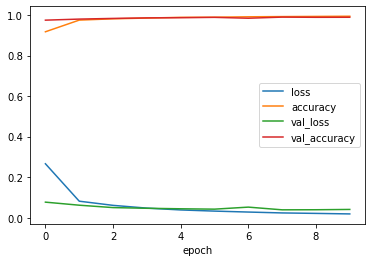

In [32]:
pd.DataFrame(H.history).plot();
plt.xlabel('epoch');

Conferindo a acurácia e as matrizes de confusão:

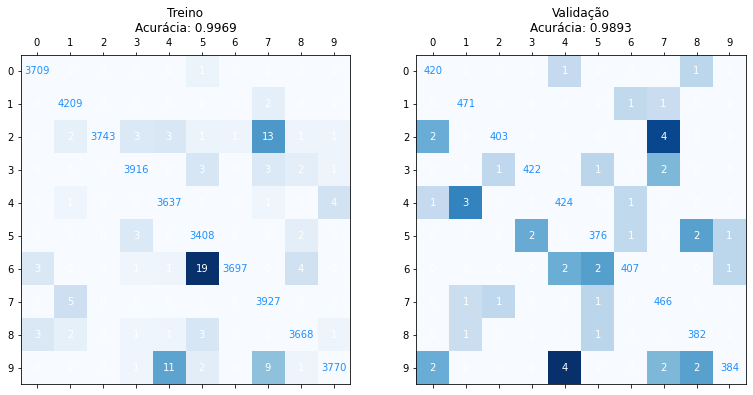

In [33]:
display_score(m)

O desempenho é melhor em relação à rede MLP!

Que tal darmos uma olhada nas imagens que a rede classificou incorretamente?

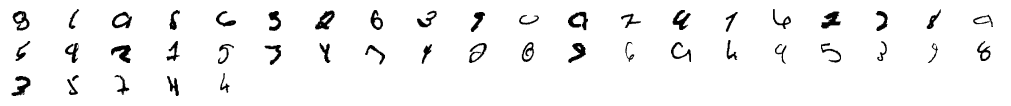

In [34]:
# localização dos exemplos na matriz de dados 
y_validacao_pred = np.argmax(m.predict(X_validacao.reshape(-1,28,28,1)), axis=1)
loc = np.where(y_validacao!=y_validacao_pred)[0]

# selecionando os dígitos, já no formato de matriz
digitos = [X_validacao[i].reshape(28,28) for i in loc]

# criando figura do matplotlib
fig, ax = plt.subplots(max(1,len(loc)//20+1),20,figsize=(18,1.7))

# plotando!
[ax.ravel()[i].imshow(digitos[i], cmap = matplotlib.cm.binary, interpolation="nearest") for i in range(len(loc))]

# desligando os eixos de todos os dígitos
[ax.ravel()[i].axis('off') for i in range(len(ax.ravel()))];

Percebe-se que alguns dígitos foram escritos de maneira bem inusual. Um exercício interessante é predizer você mesma os dígitos de cada uma dessas imagens e calcular sua "acurácia humana". Tenta aí, duvido acertar todas xD

É possível melhorar ainda mais os resultados no conjunto MNIST (esse será o tema do mão-na-massa do final da aula). Agora, vamos dar uma olhada em um estudo de caso de natureza industrial.

# Detecção de falhas em um processo de fundição

Na aula passada, estudamos o problema de detecção de falhas no contexto do controle estatístico multivariado de processos, utilizando o modelo não-supervisionado PCA. 

Nesta seção retomaremos o tema, abordando-o no contexto da visão computacional como um problema de classificação binária utilizando modelos supervisionados de redes convolucionais.

## O processo

O [conjunto de dados](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product), proveniente da companhia indiana [Pilot Technocast](http://www.pilottechnocast.com/), é composto por imagens de peças regulares e defeituosas resultantes de um processo de [fundição](https://pt.wikipedia.org/wiki/Fundi%C3%A7%C3%A3o). Nesse processo, o material metálico fundido é alimentado a um molde e, durante o resfriamento, solidifica-se na forma desejada, como ilustrado a seguir:

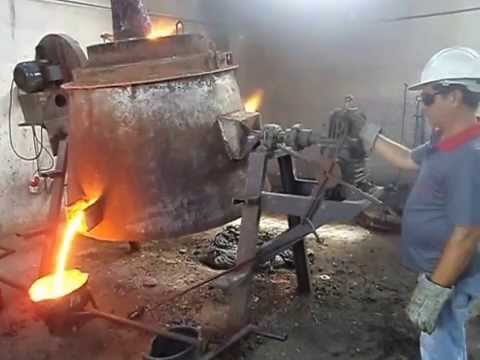

In [35]:
from IPython.display import YouTubeVideo
YouTubeVideo("4Lo3tcrz8U0")

Os [defeitos](https://en.wikipedia.org/wiki/Casting_defect) podem ser de [diferentes naturezas](http://www.jmmsassessoria.com.br/upload/files/defeitos-em-pecas-fabricadas-pelo-processo-de-fundicao.pdf): rebarbas, porosidades, trincas, defeitos na superfície, dimensões ou forma incorretas, etc. O vídeo a seguir, por exemplo, fornece dicas para que se evite o problema da porosidade:

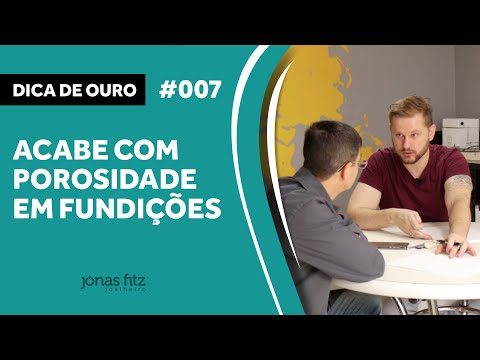

In [36]:
YouTubeVideo("mIpc2TaiZv0")

As peças em questão são impulsores de [bombas submersíveis](https://en.wikipedia.org/wiki/Submersible_pump), cujo funcionamento é ilustrado nos seguintes vídeos:

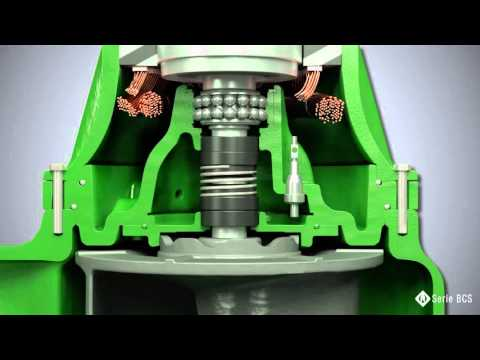

In [37]:
YouTubeVideo("UC1RVfG2AfA")

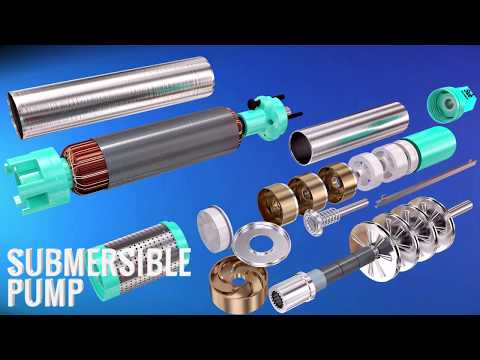

In [38]:
YouTubeVideo("L0Q6cboXyLY")

## Importando os dados

Os dados estão organizados em duas pastas, de acordo com a estrutura:

    casting_data
    ├───test
    │   ├───def_front
    │   └───ok_front
    └───train
        ├───def_front
        └───ok_front

Essa estrutura é conveniente porque, no momento da leitura pelo `keras`, há o reconhecimento das classes `def_front` e `ok_front` de acordo com os nomes das pastas.

Armazenando os caminhos:

In [39]:
technocast_PATH = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/'

technocast_train_path = technocast_PATH + 'train/'
technocast_test_path = technocast_PATH + 'test/'

Usando o `matplotlib` para dar uma olhada em duas peças aleatórias (normal e defeituosa):

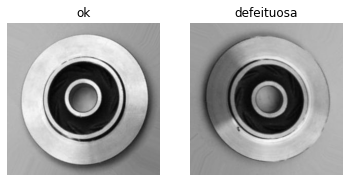

In [40]:
dir1 = technocast_train_path+'/ok_front/'
dir2 = technocast_train_path+'/def_front/'

img1 = plt.imread(dir1+random.choice(os.listdir(dir1)))
img2 = plt.imread(dir2+random.choice(os.listdir(dir2)))

fig, ax = plt.subplots(1,2)

ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('ok')

ax[1].imshow(img2)
ax[1].axis('off');
ax[1].set_title('defeituosa');

São esses dois tipos de imagens que nossos modelos precisarão distinguir!

## Gerando dados com Keras

* Aqui utilizaremos a classe [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) (disponível no módulo [keras.preprocessing.image](https://keras.io/api/preprocessing/image/)) para gerar os tensores de entrada do modelo a partir dos arquivos disponíveis nas pastas `technocast_train_path` e `technocast_test_path`. 

* Essa geração acontece em tempo real durante o treinamento: a cada iteração, um minilote de tensores é fornecido ao modelo para que um passo da minimização seja efetuado.

Na função abaixo, definimos um objeto de nome `datagen`a partir da classe `ImageDataGenerator`, especificando que os pixels serão normalizados para a faixa 0-1 (por meio da divisão por 255) e 10% dos dados serão reservados para validação. Após isso, utilizamos o método `flow_from_directory` para criar efetivamente os objetos que gerarão os minilotes de treino e de validação.

In [41]:
def make_generators():

    datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                           validation_split = 0.1)
    
    train_generator = datagen.flow_from_directory(directory = technocast_train_path, 
                                                  batch_size = 32,
                                                  target_size = (300, 300),
                                                  color_mode = "grayscale",
                                                  class_mode = "binary",
                                                  classes = {"ok_front": 0, "def_front": 1},
                                                  shuffle = True,
                                                  #seed = 0,
                                                  subset = "training")

    validation_generator = datagen.flow_from_directory(directory = technocast_train_path,
                                                       batch_size = 32,
                                                       target_size = (300, 300),
                                                       color_mode = "grayscale",
                                                       class_mode = "binary",
                                                       classes = {"ok_front": 0, "def_front": 1},
                                                       shuffle = True,
                                                       #seed = 0,
                                                       subset = "validation")
    
    return train_generator, validation_generator

Os argumentos do método `flow_from_directory` especificam que serão gerados minilotes contendo 32 imagens de tamanho 300x300 na escala de cinza (ou seja, com apenas 1 canal de cores). O problema é binário e às classes normal (`ok_front`) e defeituosa (`def_front`) foram atribuídos os rótulos 0 e 1, respectivamente. Os dados serão embaralhados e a semente da aleatoriedade foi especificada como 0.

Nesse momento, é conveniente dar uma olhada em um exemplo de minilote. Para tal, utilizaremos a função `visualizeImageBatch`:

In [42]:
def visualizeImageBatch(datagen, title):
    
    '''
    Adaptado de:
    https://www.kaggle.com/tomythoven/casting-inspection-with-data-augmentation-cnn
    '''
    
    mapping_class = {0: "0 (ok)", 1: "1 (defeituosa)"}
    
    images, labels = next(iter(datagen))
    images = images.reshape(32, *(300,300))
    
    fig, axes = plt.subplots(4, 8, figsize=(13,6.5))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 12)

    fig.tight_layout()
    fig.suptitle(title, size = 16, y = 1.05)

Visualizando um minilote:

Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.


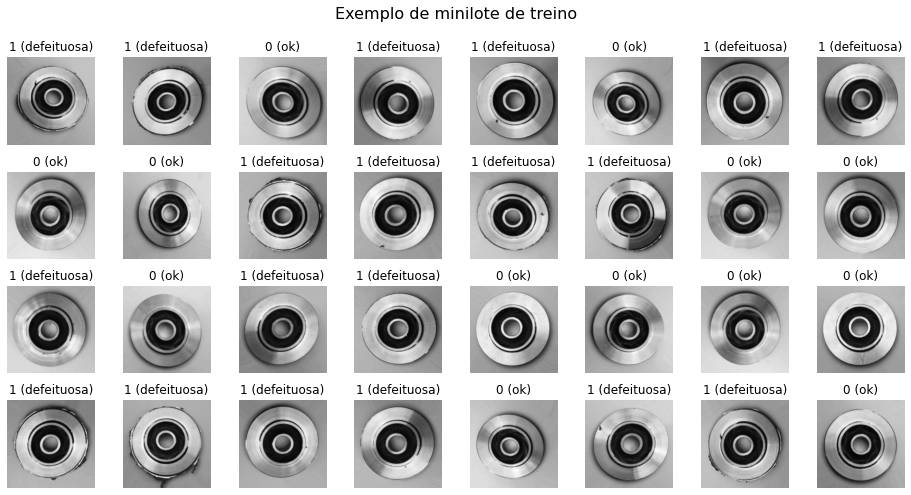

In [43]:
train_generator, validation_generator = make_generators()

visualizeImageBatch(train_generator, 'Exemplo de minilote de treino')

Agora vamos criar o gerador das imagens de teste, definido de maneira um pouco diferente:

In [44]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

n_test = sum([len(files) for r, d, files in os.walk(technocast_test_path)])

test_generator = test_datagen.flow_from_directory(directory = technocast_test_path,
                                                  batch_size = n_test,
                                                  target_size = (300, 300),
                                                  color_mode = "grayscale",
                                                  class_mode = "binary",
                                                  classes = {"ok_front": 0, "def_front": 1},
                                                  shuffle = False)

Found 715 images belonging to 2 classes.


Especificamos o tamanho do lote como o tamanho total do conjunto de teste, já que a predição de teste será efetuada com todos os dados de uma vez, após o término do treinamento.

Como fizemos no caso MNIST, é útil verificar as proporções das classes nos diferentes conjuntos:

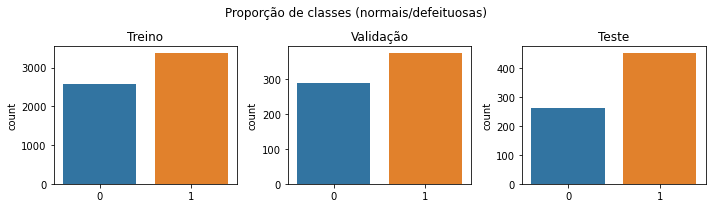

In [45]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

sns.countplot(train_generator.classes,ax=ax[0])
sns.countplot(validation_generator.classes,ax=ax[1])
sns.countplot(test_generator.classes,ax=ax[2])

ax[0].set_title('Treino')
ax[1].set_title('Validação')
ax[2].set_title('Teste')

fig.suptitle('Proporção de classes (normais/defeituosas)')
fig.tight_layout(rect=[0, 0.03, 1, 0.92]);

As proporções parecem consistentes entre os conjuntos. Poderíamos tentar corrigir a prevalência de imagens de peças defeituosas em relação às normais, mas como a diferença não é tão grande, isso não será feito.

Pronto! Já temos os objetos responsáveis por gerar nossos dados de treino, validação e teste. Podemos proceder para a etapa de modelagem.

## Modelagem

A estratégia aqui será criar múltiplas redes e juntar os vários resultados em uma única predição. É uma abordagem semelhante à que utilizamos na Aula 1 com modelos de florestas aleatórias. De maneira geral, o procedimento de criar um modelo composto por múltiplos submodelos é conhecido como [ensembling](https://en.wikipedia.org/wiki/Ensemble_learning).

A motivação para usar ensembling é a mesma da aula de florestas: a redução do erro de generalização. Lembre-se de que quanto maior for a independência entre os modelos, maior será a redução do erro. As diferenças entre as redes neste caso surgem das aleatoriedades da i) separação entre treino/validação e ii) inicialização dos pesos.

A função a seguir retorna uma rede convolucional compilada:

In [46]:
def make_cnn():

    m = keras.models.Sequential([

    keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides = 2, activation="relu", 
                        padding="same", input_shape=(300, 300, 1)),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation="relu"),

    keras.layers.Dropout(0.2),

    keras.layers.Dense(units=1, activation="sigmoid")

    ])

    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return m

Visualizando a estrutura da rede:

In [47]:
make_cnn().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 16)      800       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 128)      

Como de costume, os tamanhos dos mapas de características diminuem e o número de filtros aumenta conforme se avança na profundidade. Perceba que o primeiro campo receptivo é maior que os demais (7x7), o que pode ser conveniente para reduzir o tamanho da imagem sem perder muita informação (e como só há em geral no máximo 3 canais na terceira dimensão da entrada, a operação não é muito custosa).

Abaixo definimos um [callback](https://keras.io/api/callbacks/) para parada antecipada. *Callbacks* são objetos que efetuam ações durante o treinamento. No caso abaixo, o callback `early_stop`, definido a partir da classe [EarlyStopping](https://keras.io/api/callbacks/early_stopping/), irá monitorar a perda da validação a cada época e, caso a diminuição nas últimas 5 épocas não seja maior que $10^{-6}$, o treinamento será finalizado.

In [48]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5)

Pronto! Já podemos treinar. Na célula abaixo, as várias redes são treinadas em sequência. Repare na presença de outro callback, o `checkpoint`, instanciado da classe [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) e responsável por salvar o modelo com melhor desempenho (medido em relação à perda da validação). Isso é útil porque não necessariamente o resultado da última época é o melhor.

In [49]:
%%time

# número de redes no ensemble
n_models = 10

# listas que armazenarão os modelos e os históricos de resultados
m = [0]*n_models
H = [0]*n_models

for i in range(n_models):

    print(f'Rede {i+1}')
    print('----------------------------------------')
    
    # gerando conjuntos de treino/validaçao diferentes a cada treinamento
    train_generator, validation_generator = make_generators()
    
    # gerando o modelo
    m[i] = make_cnn()
    
    # checkpoint para salvar o melhor modelo para a rede em questão
    checkpoint = keras.callbacks.ModelCheckpoint(f"technocast_cnn_{i+1}.hdf5",
                                                 save_best_only = True,
                                                 monitor = "val_loss")
    
    print('Treinando...')
    
    # treinando a rede em questão
    H[i] = m[i].fit(train_generator, validation_data = validation_generator, 
                    epochs = 30, callbacks=[early_stop,checkpoint], verbose=0)
    
    # imprimindo resultados após o término do treino da rede em questão
    epoch_min = pd.DataFrame(H[i].history).idxmin(axis=0)['val_loss']
    print(f"Épocas: {len(H[i].history['loss'])}") 
    print(f"loss: {H[i].history['loss'][epoch_min]:.4}, accuracy: {H[i].history['accuracy'][epoch_min]:.4}")
    print(f"val_loss: {H[i].history['val_loss'][epoch_min]:.4}, val_accuracy: {H[i].history['val_accuracy'][epoch_min]:.4}")
    print('----------------------------------------\n')

Rede 1
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Treinando...
Épocas: 23
loss: 0.01998, accuracy: 0.9938
val_loss: 0.02614, val_accuracy: 0.994
----------------------------------------

Rede 2
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Treinando...
Épocas: 19
loss: 0.02196, accuracy: 0.9925
val_loss: 0.02606, val_accuracy: 0.9879
----------------------------------------

Rede 3
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Treinando...
Épocas: 23
loss: 0.01643, accuracy: 0.9953
val_loss: 0.01293, val_accuracy: 0.9955
----------------------------------------

Rede 4
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Treinando...
Épocas: 16
loss: 0.02985, accuracy: 0.9905
val_los

## Análise dos resultados

Plotando as curvas de aprendizado:

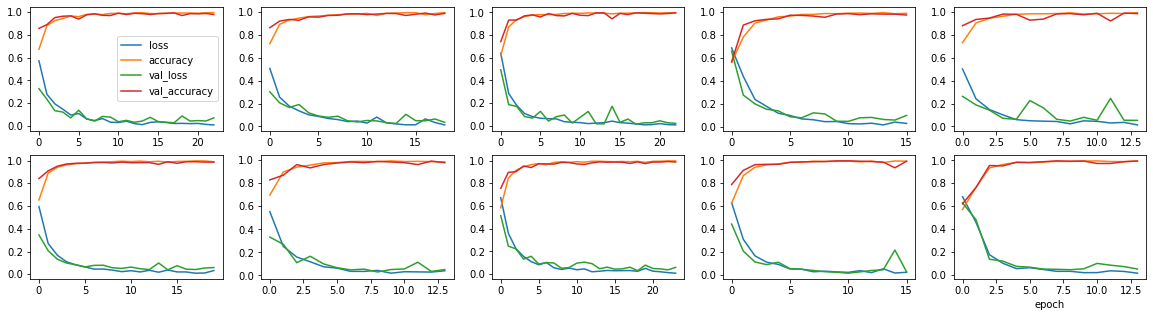

In [50]:
fig, ax = plt.subplots(2,5, figsize=(20,5))

for i in range(n_models):
    
    pd.DataFrame(H[i].history).plot(ax=ax.ravel()[i], legend = True if i==0 else False);
    plt.xlabel('epoch');

Carregando as melhores configurações de cada um dos modelos (salvas pelo callback `model_checkpoint`):

In [51]:
best_models = [keras.models.load_model(f"technocast_cnn_{i+1}.hdf5") for i in range(n_models)]

Definindo uma função para retornar a predição do ensemble:

In [52]:
def ensemble_prediction(generator):
    
    y_probs = [best_models[i].predict(generator).squeeze() for i in range(len(best_models))]
    return np.mean(np.array(y_probs), axis=0)

Lembre-se de que a rede fornece como saída, para cada imagem, uma probabilidade (ou seja, um número entre 0 e 1). Quanto mais perto de 0 está a probabilidade, mais a rede acredita que a imagem pertence à classe 0; quanto mais perto de 1, mais ela acredita que a classe é a 1. 

Na função acima, a probabilidade do ensemble é calculada como a média das probabilidades fornecidas por cada rede.

Na próxima célula, aplicamos a função para calcular as probabilidades relativas ao conjunto de teste:

In [53]:
y_probs = ensemble_prediction(test_generator)

Para calcular as métricas de classificação, é necessário definir qual faixa de probabilidades está associada a cada classe. Em outras palavras, é preciso escolher o valor de corte que separa cada uma das duas classes. A maneira mais intuitiva de efetuar esse procedimento é:

* Classe $0$: $p\leq0{,}5$
* Classe $1$: $p>0,5$.

Apesar de $0{,}5$ ser o corte mais comum, podemos variar esse valor de modo a manipular as proporções entre erros do [tipo I](https://pt.wikipedia.org/wiki/Erro_do_tipo_I) e do [tipo II](https://pt.wikipedia.org/wiki/Erro_do_tipo_II), como discutido mais adiante.

Calculando as métricas:

In [54]:
y = test_generator.classes
y_pred = y_probs>0.5

print(f'Acurácia:{sklearn.metrics.accuracy_score(y, y_pred):.4}')
print('------------------------------')
print('Matriz de confusão:')
print(sklearn.metrics.confusion_matrix(y, y_pred))

Acurácia:0.9944
------------------------------
Matriz de confusão:
[[262   0]
 [  4 449]]


Duas outras métricas adequadas para esse problema são a [precisão $P$ e a revocação $R$](https://en.wikipedia.org/wiki/Precision_and_recall). Denotando a classe negativa como sendo das amostras normais (sem defeitos) e a classe positiva como sendo das amostras com defeitos, definimos:

$$
P=\frac{VP}{VP+FP}
$$

$$
R=\frac{VP}{VP+FN}
$$

em que $VP$ é o número de verdadeiros positivos, $FP$ é o número de falsos positivos e $FN$ é o número de falsos negativos. Em essência:

* A precisão diz respeito à proporção de peças detectadas como defeituosas que está correta.
* A revocação diz respeito à proporção de peças defeituosas que são corretamente detectadas.

A precisão é uma medida de exatidão das detecções e tem a ver com qualidade; a revocação é uma medida de completude das detecções e tem a ver com quantidade. Do ponto de vista da teoria estatística de [testes de hipóteses](https://pt.wikipedia.org/wiki/Testes_de_hip%C3%B3teses), a precisão está associada a [erros do tipo I](https://pt.wikipedia.org/wiki/Erro_do_tipo_I) e a revocação está associada a [erros do tipo II](https://pt.wikipedia.org/wiki/Erro_do_tipo_II).

Uma métrica também muito usada é a [$F_1$](https://en.wikipedia.org/wiki/F1_score), a média harmônica entre precisão e revocação:

$$
F_1 = \frac{2}{1/P+1/R} $$

Na próxima célula, calculamos a precisão, a revocação e o $F_1$ de nosso modelo:

In [55]:
print(f'Precisão: {sklearn.metrics.precision_score(y, y_pred):.4}')
print(f'Revocação: {sklearn.metrics.recall_score(y, y_pred):.4}')
print(f'F1: {sklearn.metrics.f1_score(y, y_pred):.4}')

Precisão: 1.0
Revocação: 0.9912
F1: 0.9956


Existe um balanço entre precisão e revocação: quando aumentamos uma, a outra tende a diminuir. Podemos verificar esse balanço plotando as curvas de precisão e revocação em função da probabilidade de corte da saída do modelo:

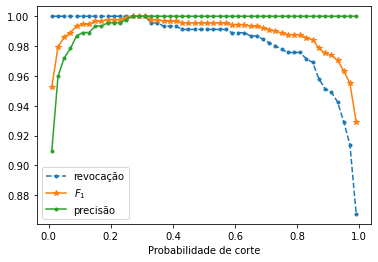

In [56]:
prob_x = np.linspace(0.01,0.99)

recall = [0]*len(prob_x)
f1 = [0]*len(prob_x)
precision = [0]*len(prob_x)

for i in range(len(prob_x)):
    y_pred_rp_curve = y_probs>prob_x[i]
    recall[i] = sklearn.metrics.recall_score(y, y_pred_rp_curve)
    f1[i] = sklearn.metrics.f1_score(y, y_pred_rp_curve)
    precision[i] = sklearn.metrics.precision_score(y, y_pred_rp_curve)

plt.plot(prob_x, recall,'.--')
plt.plot(prob_x, f1,'*-')
plt.plot(prob_x, precision,'.-')

plt.xlabel('Probabilidade de corte')
plt.legend(['revocação','$F_1$','precisão']);

A probabilidade de corte, portanto, pode ser um parâmetro definido de acordo com o interesse da companhia:

* Se deseja-se diminuir ao máximo o prejuízo causado pelo desperdício de peças boas (ou seja, diminuir o risco de falsos positivos), deve-se selecionar um corte que resulte em máxima precisão.
* Se deseja-se evitar ao máximo o envio de peças defeituosas ao cliente (ou seja, diminuir o risco de falsos negativos), deve-se selecionar um corte que resulte em máxima revocação.
* Se deseja-se um bom compromisso entre os dois cenários descritos, pode-se selecionar um corte que resulte em máximo $F_1$.

No caso de ajuste desse parâmetro, é bom que a escolha seja feita com base nos dados de validação e não de teste, de modo que possamos usar os dados de teste para verificação da adequação da escolha.

Acabamos de entender a importância da probabilidade de saída da rede para o processo de classificação. Nas próximas células, essa importância ficará ainda mais clara por meio de uma análise detalhada do conjunto de teste.

Na figura a seguir, visualizamos todas as 715 amostras do conjunto de teste junto com, respectivamente, a classe verdadeira e a probabilidade predita pelo modelo. No caso de predições equivocadas, os títulos estão em vermelho.

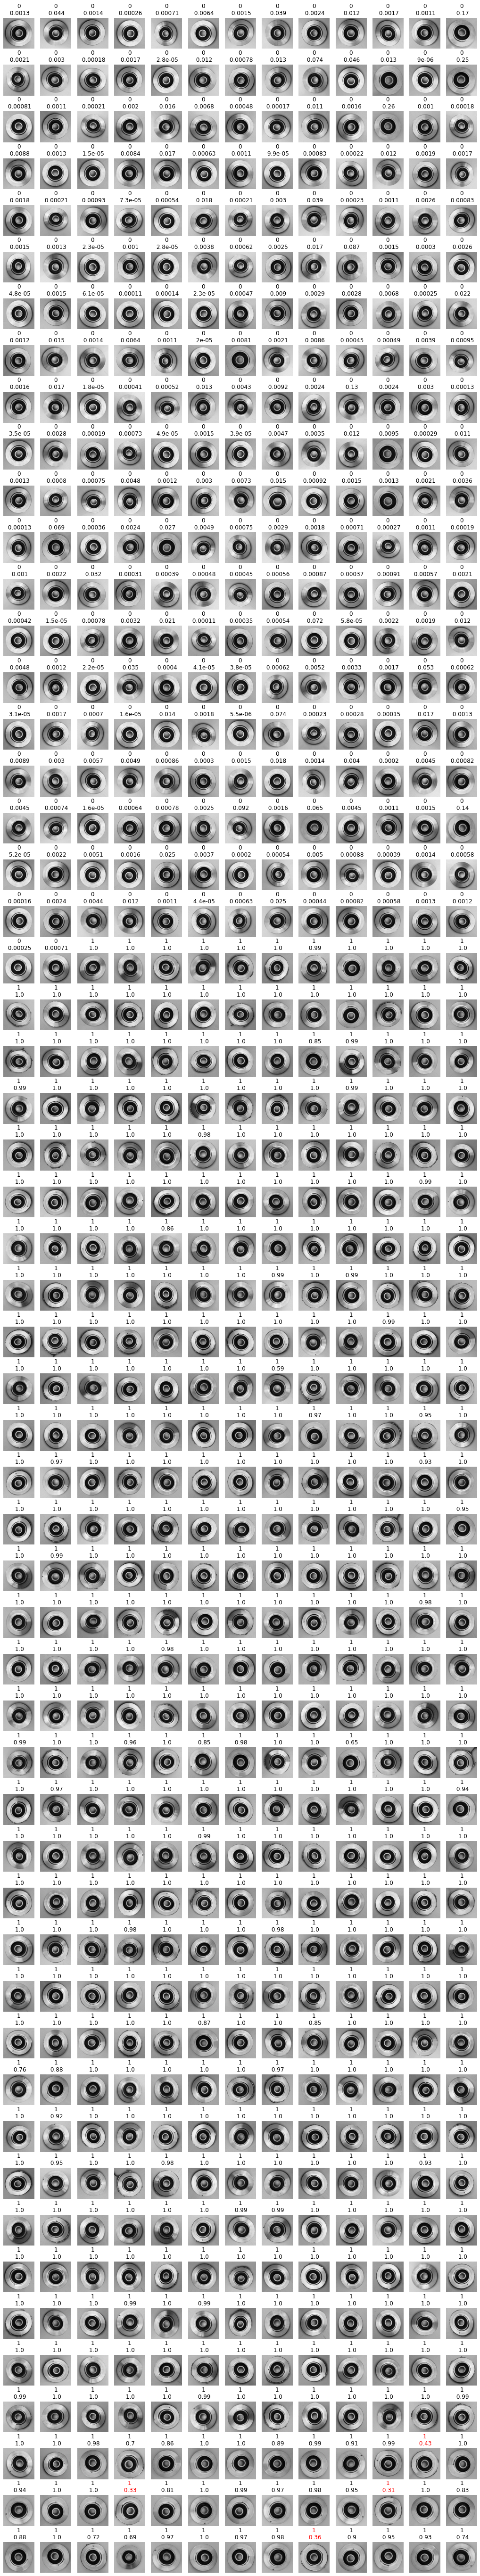

In [57]:
direc = technocast_test_path
imgs = [plt.imread(direc+file) for file in test_generator.filenames]

fig, ax = plt.subplots(715//13,13, figsize=(18,100))

for i in range(715):
    
    ax.ravel()[i].imshow(imgs[i])
    ax.ravel()[i].axis('off');
    
    color = ('black' if ((test_generator.labels[i]==0 and y_probs[i]<0.5)) or 
                        (test_generator.labels[i]==1 and y_probs[i]>=0.5) 
             else 'red')
    
    ax.ravel()[i].set_title(f'{test_generator.labels[i]}\n {y_probs[i]:.2}', color=color)

Percebe-se que a quase totalidade das predições está próxima de 0 ou 1, o que indica grande certeza do modelo quanto às classes da maioria das imagens.

Observando apenas as imagens classificadas incorretamente:

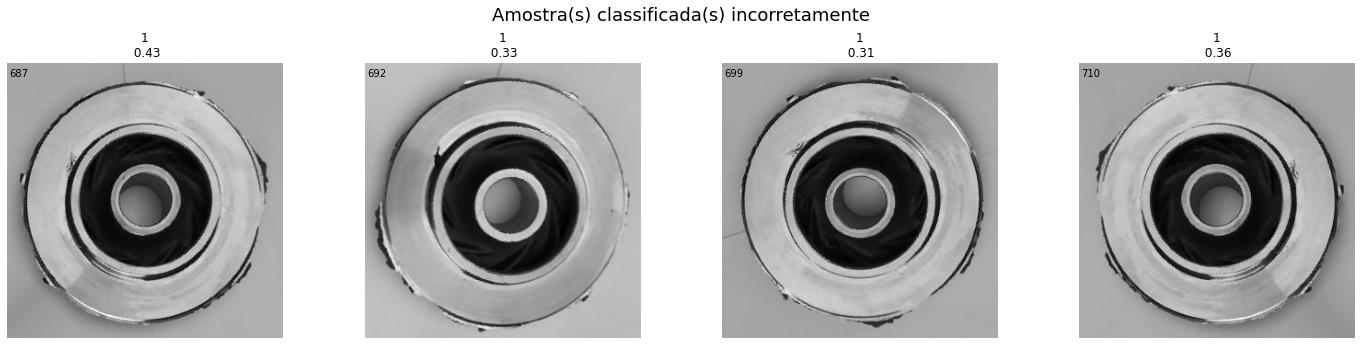

In [58]:
'''
No caso de o modelo atingir acurácia de 100%, esta célula não rodará
'''
if sklearn.metrics.accuracy_score(y, y_pred)<1:

    direc = technocast_test_path

    # selecionando as imagens com predições erradas

    wrong_positions = np.where(y!=y_pred)[0]
    wrong_files = [test_generator.filenames[i] for i in wrong_positions]

    imgs = [plt.imread(direc+file) for file in wrong_files]

    # probabilidades para as imagens com predições erradas
    y_probs_wrong = ensemble_prediction((next(test_generator)[0][wrong_positions]))

    fig, ax = plt.subplots(1,len(wrong_positions), figsize = (20,5))

    # transformando objetos ax, y_probs_wrong e wrong_positions em containers caso nao sejam
    # para podermos entrar no loop abaixo mesmo quando há apenas uma posição errada
    ax = np.array([ax]) if not hasattr(type(ax), '__iter__') else ax
    y_probs_wrong = [y_probs_wrong] if not hasattr(type(y_probs_wrong), '__iter__') else y_probs_wrong
    wrong_positions = [wrong_positions] if not hasattr(type(wrong_positions), '__iter__')  else wrong_positions

    # plotando!

    for i in range(len(wrong_positions)):

        ax[i].imshow(imgs[i])
        ax[i].axis('off');
        ax[i].set_title(f'{test_generator.labels[wrong_positions[i]]}\n {y_probs_wrong[i]:.2}')
        ax[i].text(2, 15, str(wrong_positions[i]))

    fig.suptitle('Amostra(s) classificada(s) incorretamente', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.9]);

As amostras com classificações incorretas apresentam majoritariamente predições próximas de 0,5. Esse fato pode ser usado para montar uma estratégia de revisão dos resultados do modelo. Predições cujas probabilidades estejam muito distantes de 0 ou 1 (ou seja, em que o modelo não está muito confiante quanto ao pertencimento a alguma das classes) podem ser encaminhadas para verificação humana.

Na célula abaixo, selecionamos as amostras que resultam em probabilidades distantes de 0 ou 1 (o quão distantes podem ser parâmetros ajustáveis):

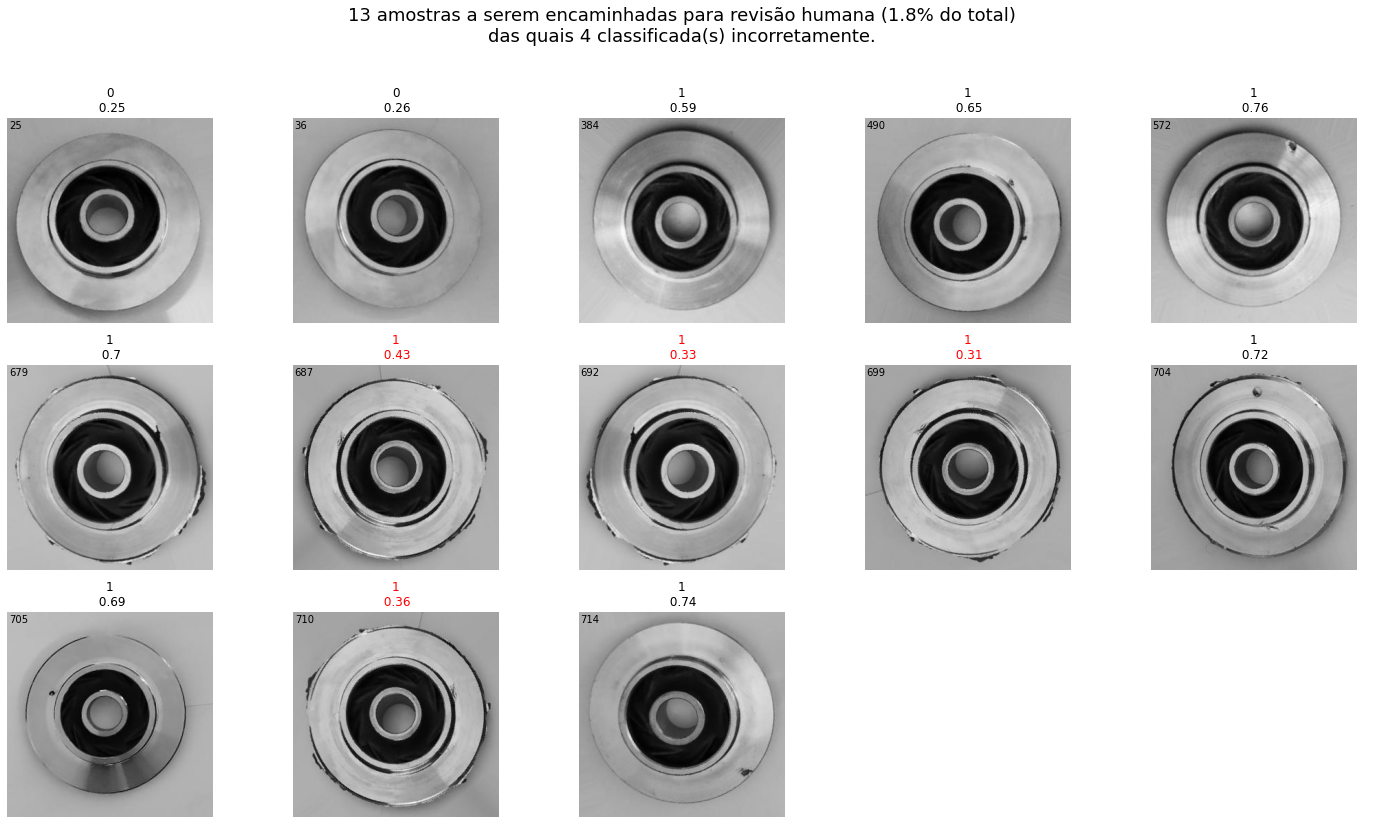

In [59]:
'''
No caso de o modelo atingir acurácia de 100%, esta célula não rodará
'''
if sklearn.metrics.accuracy_score(y, y_pred)<1:
    
    direc = technocast_test_path

    # selecionando as imagens com predições longe de 0 e 1

    mask = np.logical_and(y_probs > 0.2, y_probs < 0.8)

    unusual_prob_positions = np.where(mask)[0]
    unusual_prob_files = [test_generator.filenames[i] for i in unusual_prob_positions]

    imgs = [plt.imread(direc+file) for file in unusual_prob_files]

    # predições propriamente ditas
    y_probs_unusual = ensemble_prediction(next(test_generator)[0][unusual_prob_positions])

    # gerando a janela do gráfico

    n_columns = 5
    n_lines = max(1,max(1,len(unusual_prob_positions)//n_columns+1))

    fig, ax = plt.subplots(n_lines,n_columns, 
                           figsize = (20,4*n_lines))

    # zerando todos os eixos antes de entrarmos no loop
    [ax.ravel()[i].axis('off') for i in range(len(ax.ravel()))]

    # plotando!

    for i in range(len(unusual_prob_positions)):

        ax.ravel()[i].imshow(imgs[i])

        color = ('black' if ((test_generator.labels[unusual_prob_positions[i]]==0 and y_probs_unusual[i]<0.5)) or 
                            (test_generator.labels[unusual_prob_positions[i]]==1 and y_probs_unusual[i]>=0.5) 
                 else 'red')

        ax.ravel()[i].set_title(f'{test_generator.labels[unusual_prob_positions[i]]}\n {y_probs_unusual[i]:.2}',
                               color = color)

        ax.ravel()[i].text(2, 15, str(unusual_prob_positions[i]))

    suptitle1 = f'{len(unusual_prob_positions)} amostras a serem encaminhadas para revisão humana ({(len(unusual_prob_positions)/715*100):.2}% do total)'
    suptitle2 = f'das quais {np.in1d(unusual_prob_positions, wrong_positions).sum()} classificada(s) incorretamente.'

    fig.suptitle(suptitle1+'\n'+suptitle2,fontsize=18);

    fig.tight_layout(rect=[0, 0.03, 1, 0.9])

Percebe-se que apenas uma pequena fração das amostras encontra-se na faixa considerada suspeita (no caso acima, 0,2<p<0,8).

O uso de um ensemble de redes aumenta a acurácia geral (reduzindo as amostras nessa faixa) e ajuda também a trazer as médias das predições incertas para perto de 0,5 (o que tende a trazer as imagens com classificações incorretas para dentro dessa faixa). É um cenário favorável para a implementação de uma estratégia de revisão das predições, resultando em um sistema de detecção que pode atingir acurácia de 100% com baixo custo adicional de [HH (humano/hora)](https://en.wikipedia.org/wiki/Man-hour).

A estratégia de revisão é particularmente importante nesse processo porque mesmo baixas taxas de erro (de menos de 1%) podem resultar em consideráveis perdas econômicas, já que o custo de um único falso positivo ou negativo pode ser alto (como discutido [aqui](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product/discussion/129717)).

Se você executar este notebook, provavelmente vai obter resultados diferentes dos apresentados aqui, principalmente quanto ao número de classificações incorretas no conjunto de teste (que varia de 0 a 4, em geral). Mas, particularmente, verifiquei dois pontos consistentes ao longo de todas as execuções que efetuei:

* a precisão é mais alta que a revocação na maior parte da faixa de probabilidades de corte;
* as probabilidades das amostras classificadas incorretamente encontram-se perto de 0,5 (em geral abaixo, devido à revocação ser menor que precisão).

Talvez outra estratégia ou arquitetura leve a resultados mais estáveis. Você pode tentar :)

Para concluir, é importante fazer uma ressalva quanto à natureza dos dados de teste. Muito provavelmente, nesse conjunto, eles não refletem o ambiente de produção (em que, espera-se, a proporção de peças defeituosas seja bem menor que as normais). Portanto, na prática, todos os resultados e conclusões deveriam ser reobtidos com dados que reflitam a operação da planta industrial, que infelizmente não estão disponíveis para este estudo de caso.

***Mão na massa 4!***

* Tente aprimorar os desempenhos dos modelos deste notebook. Há margem para melhorias nos resultados e nas eficiências computacionais. Algumas sugestões:

    * Varie as arquiteturas das redes e os demais hiperparâmetros (números de filtros, taxas de dropout, etc.).
    * Crie ensembles nos casos em que usamos apenas um modelo (MNIST e Fashion MNIST). Teste várias estruturas para os ensembles (número de modelos, arquitetura de cada modelo individual, maneira de agregar os resultados, etc.).
    * Use a estratégia de [aumento de dados](https://en.wikipedia.org/wiki/Data_augmentation), que consiste em alimentar aos modelos não apenas as imagens originais e sim um conjunto potencialmente muito maior, composto por imagens com pequenas variações das originais. Você pode implementar o aumento de dados facilmente fornecendo hiperparâmetros descrevendo as variações das imagens à classe `ImageDataGenerator` (cheque a [referência](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) para mais detalhes).
    * Use modelos pré-treinados para introduzir parâmetros não-treináveis nas primeiras camadas (transferência de aprendizado).
    * etc, etc.
    
Durante seus testes, é instrutivo verificar também quais modificações não ajudam ou mesmo pioram o desempenho.
    
Na Internet, em particular no Kaggle e principalmente para o MNIST, você pode encontrar implementações das ideias citadas acima ou de outras ideias. Há material de sobra para estudo e exploração. Boa jornada!

# Conclusão

Nesta aula aprendemos o que há de mais moderno e vibrante no campo de aprendizado de máquina, os modelos de [redes neurais](https://en.wikipedia.org/wiki/Artificial_neural_network), em particular de [aprendizado profundo](https://en.wikipedia.org/wiki/Deep_learning). Estudamos dois tipos de redes, [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) e [convolucionais](https://en.wikipedia.org/wiki/Convolutional_neural_network), e entendemos porque este último é adequado para aplicações do tipo [visão computacional](https://pt.wikipedia.org/wiki/Vis%C3%A3o_computacional).

Utilizamos três conjuntos de dados: [MNIST](https://www.kaggle.com/c/digit-recognizer), [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) e [Pilot Technocast](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product/). Incentivo você a testar suas novas habilidades com outros dados. Você pode inclusive criar o seu próprio conjunto, baixando imagens do Google (para tentar diferenciar gatos de cachorros, etc). A partir de agora, o céu é o limite para você!

Até a próxima ;)